# Content

[1. Setup](#Setup)

[2. Data Cleaning and Preparation](#Data-Cleaning-&-Preparation)

# Setup¶

In [516]:
#import basic system functions
import os
import datetime
from collections import Counter
import itertools
#import python_utils
import utils

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt
import matplotlib.pyplot as mplt

%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
# If you want a style choose one
#plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'



#import libraries for time series analysis
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

#import libraries for statistics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


from IPython.display import Image
from datetime import datetime
import holidays

In [560]:
 df= pd.read_csv("/Users/brittarover/Capstone/Meteolytics/meteolytix_Artikelgruppen_Umsatz_verschiedeneStandorte.csv")

In [561]:
df.head()

Filiale       Datum  Artikelgruppe     Umsatz
0        1  2015-01-07              1  50.092235
1        1  2015-01-27              1  57.002341
2        1  2015-01-30              1  52.920825
3        1  2015-02-02              1  89.343474
4        1  2015-02-05              1  68.717498

In [5]:
df.shape

(62330, 4)

## Datacleaning and Preparation

### Modify Dataframe to define the labels as columns


**Conclusions**
- `To analyse the single labels, the different articlegroups, the dataframe needs to be restructured by using a pivot table. The result is a dataframe with one single column per articlegroup which can be used for prediction.`
- `To consider the different closed days for the filialen / stores i do it in a second step separatly for the stores.`

In [562]:
df_new=pd.pivot_table(df, values='Umsatz', index=['Datum','Filiale'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0).reset_index()

In [563]:
#create empty dataframe with 'complete' datetime index
date_df = pd.DataFrame(index=pd.date_range(start='1/1/2015', end=df.Datum.max()))
df_new_1 = pd.pivot_table(df[df.Filiale == 1], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_1=df_new_1.merge(date_df, how='right', left_index= True,right_index=True).fillna(0)
df_new_1.index = df_new_1.index.set_names(['Datum'])
df_new_1=df_new_1.reset_index()

df_new_2 = pd.pivot_table(df[df.Filiale == 2], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_2 = df_new_2.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_2.index = df_new_2.index.set_names(['Datum'])
df_new_2=df_new_2.reset_index()

df_new_3 = pd.pivot_table(df[df.Filiale == 3], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_3 = df_new_3.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_3.index = df_new_3.index.set_names(['Datum'])
df_new_3=df_new_3.reset_index()

### Adding Warengruppeninfo

**Conclusions**
- `I introduce Warengruppen given by meterolytics to give an better overall picture to the sales trends.`

In [564]:
# Adding Warenguppeninfo
df['Warengruppe']=df['Artikelgruppe'].apply(lambda x: "Brot" if x in (1,2,3,4,5) else "Brötchen" if x in (6,7) 
                                            else "Spezial_Brötchen" if x==8 else
                                              "Konditorei" if x in (9,10) else "Kuchen" if x in (11,12) else "Weihnachtsartikel") 

In [565]:
df_new_waren = pd.pivot_table(df, values='Umsatz', index=['Datum','Filiale'],
                    columns=['Warengruppe'], aggfunc=np.sum, fill_value=0).reset_index()

In [566]:
# Renaming Artikelgruppe for all new dataframes
liste=[df_new,df_new_1,df_new_2,df_new_3,df_new_waren]

for i in liste:
  i.rename(columns={1:'Weizenbrot',2:"Mischbrot",3:'Vollkornbrot',4:"Stangenbrote",5:"Spezialbrot",6 : "Brötchen",
                       7 : "Süsse_Brötchen",8 :"Herzhafte_Brötchen",9 : "KonditoreiBlech1",10: "KonditoreiBlech2",
                       11: "Stückgebäck", 12:"Blechkuchen",13 : "Weihnachtsartikel"
                          }, 
                 inplace=True)

### Adding a Gesamt Column

In [567]:
#Adding a Gesamt column to all the new dataframes which contains the total sales
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:
    i['Gesamt']=i['Vollkornbrot']+i['Mischbrot']+i['Stangenbrote']+i['Weizenbrot']+i['Spezialbrot']+i['Brötchen']
    +i['Süsse_Brötchen']+i['Herzhafte_Brötchen']+i['KonditoreiBlech1']+i['KonditoreiBlech2']+i['Blechkuchen']
    +i['Weihnachtsartikel']+i['Stückgebäck']


### Columns Definition

- **Filiale** - There are three different filial stores which are analyzed, one direct in the city (filiale=1), one near the water front (filiale=2) and the third in a residential area (filiale=3)
1 = city; 2 = waterfront area; 3 = city disctrict
- **Datum** - date of the sales data. The period 
- **Warengruppe** - main article group
1 = Brot; 2 = Brötchen; 3 = Spezial_Brötchen; 4 = Konditorei; 5 = Kuchen; 6 = Weihnachtsartikel    
- **Artikelgruppe** - article group
1 = Weizenbrot; 2 = Mischbrot; 3 = Vollkornbrot; 4 = Spezialbrot; 5 = Stangenbrote; 6 = Brötchen; 7 = Süße Brötchen; 8 = Herzhafte Brötchen; 9 = KonditoreiBlech1; 10 = KonditoreiBlech2; 11 = Stückgebäck; 12 = Blechkuchen; 13 = Weiohnachtsartikel;     
- **Umsatz** - Sales volumne per day and article group   

### Transformation to Datetime

In [568]:
# Transformation to Datetime
liste=[df,df_new,df_new_1,df_new_2,df_new_3,df_new_waren]

for i in liste:
  i['Datum'] = pd.to_datetime(i['Datum'])


### Additional Date columns

In [569]:
for i in liste:
   i['Wochentag']=i['Datum'].dt.weekday
   i['Jahr']=i['Datum'].dt.year
   i['Monat']=i['Datum'].dt.month
   i['Wochenende']=i['Wochentag'].apply(lambda x: 'Wochentag' if x in (0,1,2,3,4) else 'Wochenende')
    

## Modifikations through EDA and Featureengineering

In [22]:
df_basis_1=df_new_1.iloc[:,1:13]
df_basis_2=df_new_2.iloc[:,1:13]
df_basis_3=df_new_3.iloc[:,1:13]


### Putting KonditoreiBlech 1 and KonditoreiBlech2 together

In [570]:
df_new_1['KonditoreiBlech1']=df_new_1['KonditoreiBlech1']+df_new_1['KonditoreiBlech2']
df_new_1.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_1.drop('KonditoreiBlech2',axis='columns', inplace=True)

df_new_2['KonditoreiBlech1']=df_new_2['KonditoreiBlech1']+df_new_2['KonditoreiBlech2']
df_new_2.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_2.drop('KonditoreiBlech2',axis='columns', inplace=True)

df_new_3['KonditoreiBlech1']=df_new_3['KonditoreiBlech1']+df_new_3['KonditoreiBlech2']
df_new_3.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_3.drop('KonditoreiBlech2',axis='columns', inplace=True)

## Feature Engineering

### Flag Wochenende

In [571]:
#Change of the Wochenende column
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:

   i['Wochenende_flag']=i['Wochenende'].apply(lambda x: 1 if x=='Wochenende' else 0)

In [572]:
df_new_2.drop(columns=['Wochenende'],inplace=True)

### Saison

In [573]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return  1
    if date in seasons['summer']:
        return 2
    if date in seasons['autumn']:
        return 3
    else:
        return 4

In [574]:
# Assuming df has a date column of type `datetime`
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:
   i['Season'] = i.Datum.map(season_of_date)

### Public Holidays via package holidays

In [575]:
#Definition of Feiertage
de_celebration_days=[]
for date in holidays.Germany(years=2020).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years =2019).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2018).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2017).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2016).items():
    de_celebration_days.append(str(date[0]))
for date in holidays.Germany(years=2015).items():
    de_celebration_days.append(str(date[0]))   

In [576]:
#Definition of new column Feiertage_DE
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:

   i['Feiertag_DE']=i['Datum'].apply(lambda x: 1 if x.strftime(format = "%Y-%m-%d") in de_celebration_days else 0)

### School Holidays Schleswig Holstein

In [577]:
# Define holidays
holidays_sh = pd.DataFrame({'date':pd.date_range('2019-12-23', '2020-01-06')})
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2020-03-31', '2020-04-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-12-10', '2019-01-04')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-04-04', '2019-04-18')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-05-30', '2019-05-30')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-07-01', '2019-08-08')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2019-10-05', '2019-10-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-12-21', '2018-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-03-29', '2018-04-13')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-05-11', '2018-05-11')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-07-09', '2018-08-17')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2018-10-01', '2018-10-19')}))    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-12-23', '2017-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-04-07', '2017-04-21')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-05-26', '2017-05-26')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-07-24', '2017-09-02')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2017-10-16', '2017-10-27')}))       
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-12-21', '2016-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-03-24', '2016-04-09')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-05-16', '2016-05-16')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-07-25', '2016-09-02')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2016-10-17', '2016-10-29')}))    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2014-12-22', '2015-01-06')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-04-01', '2015-04-17')}))
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-05-11', '2015-05-11')}))                    
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-07-20', '2015-08-29')}))               
holidays_sh = holidays_sh.append(pd.DataFrame({'date':pd.date_range('2015-10-19', '2015-10-31')}))    


holidays_sh = holidays_sh.sort_values('date') 
holidays_sh['Holidays_SH']=1

In [ ]:
# Merge with dataframes
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:
   i=pd.merge(i,holidays_sh,left_on='Datum',right_on='date',how='left').fillna(0)
   i.drop(columns=['date'],inplace=True)

In [578]:
df_new_2=pd.merge(df_new_2,holidays_sh,left_on='Datum',right_on='date',how='left').fillna(0)

In [579]:
df_new_2.drop(columns=['date'],inplace=True)

#### Sommerferien für Prophet

In [217]:
HOLIDAYS_SH_SOMMER = pd.DataFrame({
  'holiday': 'Sommer',
  'ds': pd.to_datetime(['2015-07-20','2016-07-25','2017-07-24','2018-07-09','2019-07-01']),
  'lower_window': -2,
  'upper_window': 42,
})

#### Oster- and Herbst-Holidays for Prophet

In [223]:
OSTERN = pd.DataFrame({
  'holiday': 'Ostern',
  'ds': pd.to_datetime(['2019-04-04','2018-03-29','2016-03-24','2017-04-07','2015-04-01']),
  'lower_window': 0,
  'upper_window': 18,
})

OSTERN.loc[OSTERN.ds=='2017-04-07','upper_window']=17
OSTERN.loc[OSTERN.ds=='2015-04-01','upper_window']=19
OSTERN.loc[OSTERN.ds=='2019-04-04','upper_window']=15

In [224]:
HERBST = pd.DataFrame({
  'holiday': 'Herbst',
  'ds': pd.to_datetime(['2015-10-19','2016-10-17','2017-10-16','2019-10-07','2018-10-01']),
  'lower_window': -2,
  'upper_window': 13,
})
HERBST.loc[HERBST.ds=='2018-10-01','upper_window']=20

In [225]:
HOLIDAYS_SH_ALL=pd.concat((HERBST, OSTERN))

In [226]:
HOLIDAYS_SH_ALL

holiday         ds  lower_window  upper_window
0  Herbst 2015-10-19            -2            13
1  Herbst 2016-10-17            -2            13
2  Herbst 2017-10-16            -2            13
3  Herbst 2019-10-07            -2            13
4  Herbst 2018-10-01            -2            20
0  Ostern 2019-04-04             0            15
1  Ostern 2018-03-29             0            18
2  Ostern 2016-03-24             0            18
3  Ostern 2017-04-07             0            17
4  Ostern 2015-04-01             0            19

### Verkaufsfreie Sonntage and Kieler Woche

In [580]:
# Definition of events
kieler_woche= pd.DataFrame({'date':pd.date_range('2019-06-22', '2019-06-30')})
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2018-06-16', '2018-06-24')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2017-06-17', '2017-06-25')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2016-06-18', '2016-06-26')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2015-06-20', '2015-06-28')}))

In [581]:
kieler_woche['Datum']=kieler_woche['date'].apply(lambda x: x.strftime(format = "%Y-%m-%d"))
liste_kw=kieler_woche['Datum'].tolist()

In [582]:
#Definition of new column Kieler Woche
liste=[df_new_2]

for i in liste:
    
   i['Kieler_Woche']=i['Datum'].apply(lambda x: 1 if x.strftime(format = "%Y-%m-%d") in liste_kw else 0)

In [583]:
#Check
df_new_2['Kieler_Woche'].value_counts()

0    1934
1      45
Name: Kieler_Woche, dtype: int64

#### Kieler Woche for Prophet

In [213]:
Kieler_Woche= pd.DataFrame({
  'holiday': 'Kieler_Woche',
  'ds': pd.to_datetime(['2015-06-20','2016-06-18','2017-06-17','2018-06-16','2019-06-22']),
  'lower_window': 0,
  'upper_window': 8,
})

### Flag Closed

In [552]:
#Definition of new column Closed
liste=[df_new_1,df_new_2,df_new_3]

for i in liste:
   i['Closed']=i['Gesamt'].apply(lambda x: 1 if x==0 else 0)
   i['Closed']=pd.to_numeric(i['Closed'])

#### Closed for Prophet

In [259]:
CLOSED=df_new_2.query('Gesamt==0').Datum

In [260]:
closed=[i.strftime(format = "%Y-%m-%d") for i in CLOSED]

In [261]:
Closed = pd.DataFrame({
  'holiday': 'Closed',
  'ds': pd.to_datetime(['2015-01-01',
 '2015-04-03',
 '2015-05-01',
 '2015-12-25',
 '2015-12-26',
 '2016-01-01',
 '2016-03-24',
 '2016-03-25',
 '2016-07-07',
 '2016-07-18',
 '2016-08-14',
 '2016-08-15',
 '2016-12-17',
 '2016-12-25',
 '2016-12-26',
 '2017-01-01',
 '2017-04-14',
 '2017-05-01',
 '2017-07-04',
 '2017-10-23',
 '2017-10-31',
 '2017-12-25',
 '2017-12-26',
 '2018-01-01',
 '2018-03-30',
 '2018-05-01',
 '2018-05-21',
 '2018-10-31',
 '2018-12-25',
 '2018-12-26',
 '2019-01-01',
 '2019-03-20',
 '2019-04-03',
 '2019-04-19',
 '2019-05-01',
 '2019-07-10',
 '2019-10-31',
 '2019-12-25',
 '2019-12-26',
 '2020-01-01',
 '2020-04-10',
 '2020-05-01',
 '2020-05-03',
 '2020-05-06',
 '2020-05-07']),
  'lower_window': 0,
  'upper_window': 1,
})

In [262]:
Closed

holiday         ds  lower_window  upper_window
0   Closed 2015-01-01             0             1
1   Closed 2015-04-03             0             1
2   Closed 2015-05-01             0             1
3   Closed 2015-12-25             0             1
4   Closed 2015-12-26             0             1
5   Closed 2016-01-01             0             1
6   Closed 2016-03-24             0             1
7   Closed 2016-03-25             0             1
8   Closed 2016-07-07             0             1
9   Closed 2016-07-18             0             1
10  Closed 2016-08-14             0             1
11  Closed 2016-08-15             0             1
12  Closed 2016-12-17             0             1
13  Closed 2016-12-25             0             1
14  Closed 2016-12-26             0             1
15  Closed 2017-01-01             0             1
16  Closed 2017-04-14             0             1
17  Closed 2017-05-01             0             1
18  Closed 2017-07-04             0             1
19  Closed 2017-10-23             0             1
20  Closed 2017-10-31             0             1
21  Closed 2017-12-25             0             1
22  Closed 2017-12-26             0             1
23  Closed 2018-01-01             0             1
24  Closed 2018-03-30             0             1
25  Closed 2018-05-01             0             1
26  Closed 2018-05-21             0             1
27  Closed 2018-10-31             0             1
28  Closed 2018-12-25             0             1
29  Closed 2018-12-26             0             1
30  Closed 2019-01-01             0             1
31  Closed 2019-03-20             0             1
32  Closed 2019-04-03             0             1
33  Closed 2019-04-19             0             1
34  Closed 2019-05-01             0             1
35  Closed 2019-07-10             0             1
36  Closed 2019-10-31             0             1
37  Closed 2019-12-25             0             1
38  Closed 2019-12-26             0             1
39  Closed 2020-01-01             0             1
40  Closed 2020-04-10             0             1
41  Closed 2020-05-01             0             1
42  Closed 2020-05-03             0             1
43  Closed 2020-05-06             0             1
44  Closed 2020-05-07             0             1

### Wheather data from dwd/weste


In [585]:
# Import Wetterdata
df_wetter = pd.read_csv("Wetterdaten_Kiel_gesamt.csv",delimiter=';')

In [590]:
df_wetter['Sonne_h']=df_wetter['Sonne_h'].interpolate(method='linear')

In [592]:
df_wetter.head()

Datum Niederschlag Sonne_h Temperatur_max
0  01.01.2015            8       0            6,2
1  02.01.2015          2,2     0,7            9,5
2  03.01.2015          4,2       0            5,9
3  04.01.2015            0     4,7            5,8
4  05.01.2015          0,2       0            6,1

In [587]:
df_wetter.drop(columns=['Unnamed: 4'],inplace=True)

In [555]:
df_wetter.Datum=pd.to_datetime(df_wetter['Datum'])

In [559]:
df_new_2=df_new_2.merge(df_wetter, how='left', left_index= True,right_index=True)
df_new_2.drop(columns=['Datum_y'],inplace=True)
df_new_2.rename(columns={'Datum_x':'Datum'},inplace=True)
df_new_2.tail(30).T

1949                 1950  \
Datum               2020-05-03 00:00:00  2020-05-04 00:00:00   
Weizenbrot                            0              56.1272   
Mischbrot                             0              86.4499   
Vollkornbrot                          0              142.499   
Stangenbrote                          0              33.8346   
Spezialbrot                           0              53.3073   
Brötchen                              0              285.895   
Süsse_Brötchen                        0               170.76   
Herzhafte_Brötchen                    0              62.0091   
KonditoreiBlech                       0              28.5038   
Stückgebäck                           0              150.526   
Blechkuchen                           0              73.0577   
Weihnachtsartikel                     0                    0   
Gesamt                                0              658.113   
Wochentag                             6                    0   
Jahr                               2020                 2020   
Monat                                 5                    5   
Wochenende_flag                       1                    0   
Season                                1                    1   
Feiertag_DE                           0                    0   
Holidays_SH                           0                    0   
Kieler_Woche                          0                    0   
Closed                                1                    0   
Niederschlag_x                      NaN                  NaN   
Sonne_h_x                           NaN                  NaN   
Temperatur_max_x                    NaN                  NaN   
Niederschlag_y                      NaN                  NaN   
Sonne_h_y                           NaN                  NaN   
Temperatur_max_y                    NaN                  NaN   
Niederschlag_x                      NaN                  NaN   
Sonne_h_x                           NaN                  NaN   
Temperatur_max_x                    NaN                  NaN   
Niederschlag_y                      NaN                  NaN   
Sonne_h_y                           NaN                  NaN   
Temperatur_max_y                    NaN                  NaN   

                                   1951                 1952  \
Datum               2020-05-05 00:00:00  2020-05-06 00:00:00   
Weizenbrot                      56.3915                    0   
Mischbrot                       81.7123                    0   
Vollkornbrot                    131.467                    0   
Stangenbrote                    11.5251                    0   
Spezialbrot                     69.5346                    0   
Brötchen                        308.741                    0   
Süsse_Brötchen                  144.958                    0   
Herzhafte_Brötchen              85.0033                    0   
KonditoreiBlech                 50.9265                    0   
Stückgebäck                     118.605                    0   
Blechkuchen                     113.079                    0   
Weihnachtsartikel                     0                    0   
Gesamt                          659.372                    0   
Wochentag                             1                    2   
Jahr                               2020                 2020   
Monat                                 5                    5   
Wochenende_flag                       0                    0   
Season                                1                    1   
Feiertag_DE                           0                    0   
Holidays_SH                           0                    0   
Kieler_Woche                          0                    0   
Closed                                0                    1   
Niederschlag_x                      NaN                  NaN   
Sonne_h_x                           NaN                  NaN   
Temperatur_max_x                    NaN                  NaN   
Ni

In [42]:
liste=[df_new_2]

for i in liste:
    
   i.Niederschlag=i.Niederschlag.apply(lambda x: str(x).replace(",", "."))
   i.Sonne_h=i.Sonne_h.apply(lambda x: str(x).replace(",", "."))
   i.Temperatur_max=i.Temperatur_max.apply(lambda x: str(x).replace(",", "."))

In [43]:
liste=[df_new_2]

for i in liste:

   i['Niederschlag']=pd.to_numeric(i['Niederschlag'])
   i['Sonne_h']=pd.to_numeric(i['Sonne_h'])
   i['Temperatur_max']=pd.to_numeric(i['Temperatur_max'])

### Timerelated Features for Salesvolumne in the past

#### Values of the previous week and year

In [45]:
# Value of the previous Year
df_new_2['Brötchen_364'] = df_new_2.Brötchen.shift(364)
df_new_2['Brötchen_364'].fillna(0)

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
1974    564.408017
1975    528.975194
1976    593.424106
1977    517.679428
1978    256.875343
Name: Brötchen_364, Length: 1979, dtype: float64

In [46]:
#Value of the previous Week
df_new_2['Brötchen_7'] = df_new_2.Brötchen.shift(7)
df_new_2['Brötchen_7'].fillna(0)

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
1974    604.296365
1975    614.900559
1976    637.206699
1977    641.237676
1978    383.967478
Name: Brötchen_7, Length: 1979, dtype: float64

In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']
numbers=[7,364]

for i in var:
    for j in numbers:
       df_new_2["%s_%d" % (i,j)]=df_new_2[i].shift(j)
       df_new_2["%s_%d" % (i,j)].fillna(0)

#### mean and max-Values for Weekday and Monthly Values

**Conclusions**
- `Mean and Maxvalues have no significant impact to the correlation. I need to do it for Months and Weekdays.`


In [ ]:
# Definition on weekldaybase
def Brötchen_mean(x):
    return df_new_2.groupby('Wochentag')['Brötchen'].mean()[x]
def Brötchen_max(x):
    return df_new_2.groupby('Wochentag')['Brötchen'].max()[x]


In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_mean"
    
    def name(x):
        return df_new_2.groupby('Wochentag')['%s' % (i)].mean()[x]

    df_new_2['%s_mean_WD' % (i)]=df_new_2['Wochentag'].apply(lambda x:  name(x))
                                   

In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_max"
    
    def name(x):
        return df_new_2.groupby('Wochentag')['%s' % (i)].mean()[x]

    df_new_2['%s_max_WD' % (i)]=df_new_2['Wochentag'].apply(lambda x:  name(x))

In [ ]:
def Brötchen_mean_M(x):
    return df_new_2.groupby('Monat')['Brötchen'].mean()[x]
def Brötchen_max_M(x):
    return df_new_2.groupby('Monat')['Brötchen'].max()[x]


In [ ]:
df_new_2['Brötchen_mean_M']=df_new_2['Monat'].apply(lambda x:  Brötchen_mean_M(x))
df_new_2['Brötchen_max_M']=df_new_2['Monat'].apply(lambda x:  Brötchen_max_M(x))


In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']

for i in var:
    name=i+ "_mean"
    
    def name(x):
        return df_new_2.groupby('Monat')['%s' % (i)].mean()[x]

    df_new_2['%s_mean_M' % (i)]=df_new_2['Monat'].apply(lambda x:  name(x))

In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_max"
    
    def name(x):
        return df_new_2.groupby('Monat')['%s' % (i)].mean()[x]

    df_new_2['%s_max_M' % (i)]=df_new_2['Monat'].apply(lambda x:  name(x))
                                   

## Distribution

In [326]:
# Valuation of agg.Values
df_new_2.describe().T

count         mean         std     min          25%  \
Weizenbrot          1979.0    63.447962   29.216742     0.0    60.117258   
Mischbrot           1979.0    71.860719   20.052765     0.0    60.991450   
Vollkornbrot        1979.0   108.283982   26.926271     0.0    95.047923   
Stangenbrote        1979.0    39.816439   17.646559     0.0    30.038129   
Spezialbrot         1979.0    56.310284   26.874605     0.0    51.758903   
Brötchen            1979.0   375.431206  138.927415     0.0   273.886926   
Süsse_Brötchen      1979.0   196.670399   57.579214     0.0   161.334074   
Herzhafte_Brötchen  1979.0    93.947422   36.940020     0.0    70.681393   
KonditoreiBlech     1979.0    98.692646   64.111577     0.0    54.576132   
Stückgebäck         1979.0   152.085738   89.090462     0.0   121.227612   
Blechkuchen         1979.0    93.154924   46.648699     0.0    61.066615   
Weihnachtsartikel   1979.0    21.198583   53.875080     0.0     0.000000   
Gesamt              1979.0   715.150591  181.970439     0.0   614.870943   
Wochentag           1979.0     3.001516    2.000884     0.0     1.000000   
Jahr                1979.0  2017.231430    1.577458  2015.0  2016.000000   
Monat               1979.0     6.253158    3.465719     1.0     3.000000   
Wochenende_flag     1979.0     0.286003    0.452005     0.0     0.000000   
Season              1979.0     2.492168    1.151477     1.0     1.000000   
Feiertag_DE         1979.0     0.026276    0.159995     0.0     0.000000   
Holidays_SH         1979.0     0.237494    0.425655     0.0     0.000000   
Kieler_Woche        1979.0     0.022739    0.149107     0.0     0.000000   
Closed              1979.0     0.022739    0.149107     0.0     0.000000   
Niederschlag        1979.0     2.008085    3.922612     0.0     0.000000   
Sonne_h             1979.0     3.623483    4.501013     0.0     0.000000   
Temperatur_max      1979.0    13.282820    7.451813    -5.1     7.600000   
Brötchen_364        1615.0   369.496120  134.768593     0.0   271.039901   
Brötchen_7          1972.0   374.798441  138.438383     0.0   273.735775   

                            50%          75%          max  
Weizenbrot            71.638075    81.295926   120.423144  
Mischbrot             73.463033    84.206328   152.746146  
Vollkornbrot         108.428509   123.201725   225.035588  
Stangenbrote          39.332197    49.454939   198.752191  
Spezialbrot           61.850288    71.343340   200.259200  
Brötchen             355.500769   462.666723   820.516093  
Süsse_Brötchen       185.408152   228.537989   428.071519  
Herzhafte_Brötchen    87.759013   111.181716   268.706655  
KonditoreiBlech       73.102484   150.262028   399.988543  
Stückgebäck          145.715536   172.554556  1798.588913  
Blechkuchen           87.470191   119.576307   338.496148  
Weihnachtsartikel      0.000000     0.000000   245.976731  
Gesamt               701.781576   812.942889  1433.695516  
Wochentag              3.000000     5.000000     6.000000  
Jahr                2017.000000  2019.000000  2020.000000  
Monat                  6.000000     9.000000    12.000000  
Wochenende_flag        0.000000     1.000000     1.000000  
Season                 2.000000     4.000000     4.000000  
Feiertag_DE            0.000000     0.000000     1.000000  
Holidays_SH            0.000000     0.000000     1.000000  
Kieler_Woche           0.000000     0.000000     1.000000  
Closed                 0.000000     0.000000     1.000000  
Niederschlag           0.100000     2.300000    37.700000  
Sonne_h                1.317000     6.450000    16.550000  
Temperatur_max        12.700000    19.400000    35.100000  
Brötchen_364         349.506964   453.992079   810.818652  
Brötchen_7           354.921694   462.412270   820.516093

## Correlations

<function matplotlib.pyplot.show(close=None, block=None)>

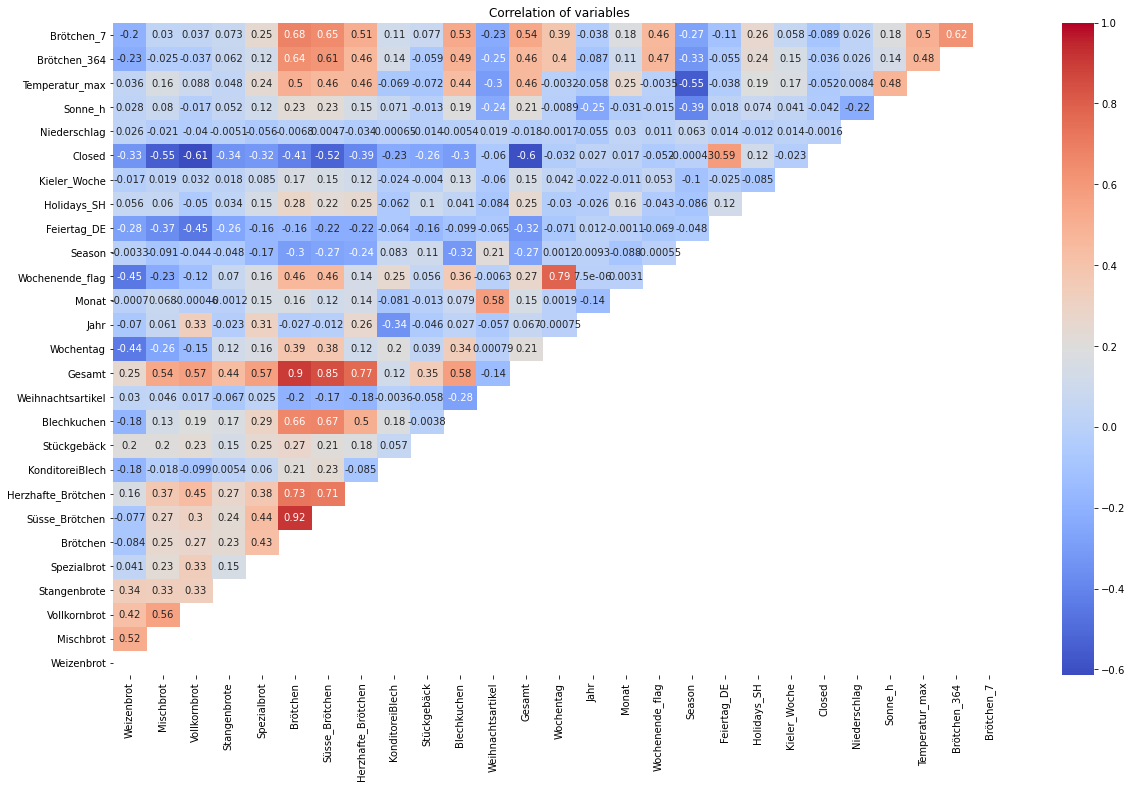

In [324]:
#First we create a new DataFrame with only numerical features
numerics = ['int64', 'float64']

num_df = df_new_2.select_dtypes(include=numerics)

#Korrelationsanalyse
mask = np.triu( num_df.corr())
plt.figure(figsize=(20,12))
plt.title('Correlation of variables')
ax=sns.heatmap(num_df.corr(),vmax=1.0,annot=True,mask=mask,cmap='coolwarm')
plt.savefig('correlogram_simple.png')
ax.set_ylim((0,27))
plt.show

# Checks Timeseries

## Decompose weekly, monthly and yearly effects as well as trends

In [47]:
df_newmodel_2 = df_new_2.copy().set_index('Datum')

In [ ]:
#df_new_1_index=df_newmodel_1.set_index('Datum')
#df_new_2_index=df_newmodel_2.set_index('Datum')
#df_new_3_index=df_newmodel_1.set_index('Datum')

### Exploration for Filiale in total 2

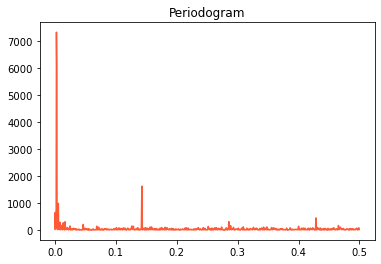

In [355]:
# We use for the sampling frequency 1 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(df_newmodel_2.Gesamt, fs = 1, window='hanning', scaling='spectrum')
plt.plot(f, Pxx, color = NF_ORANGE)
plt.title('Periodogram')
plt.show()

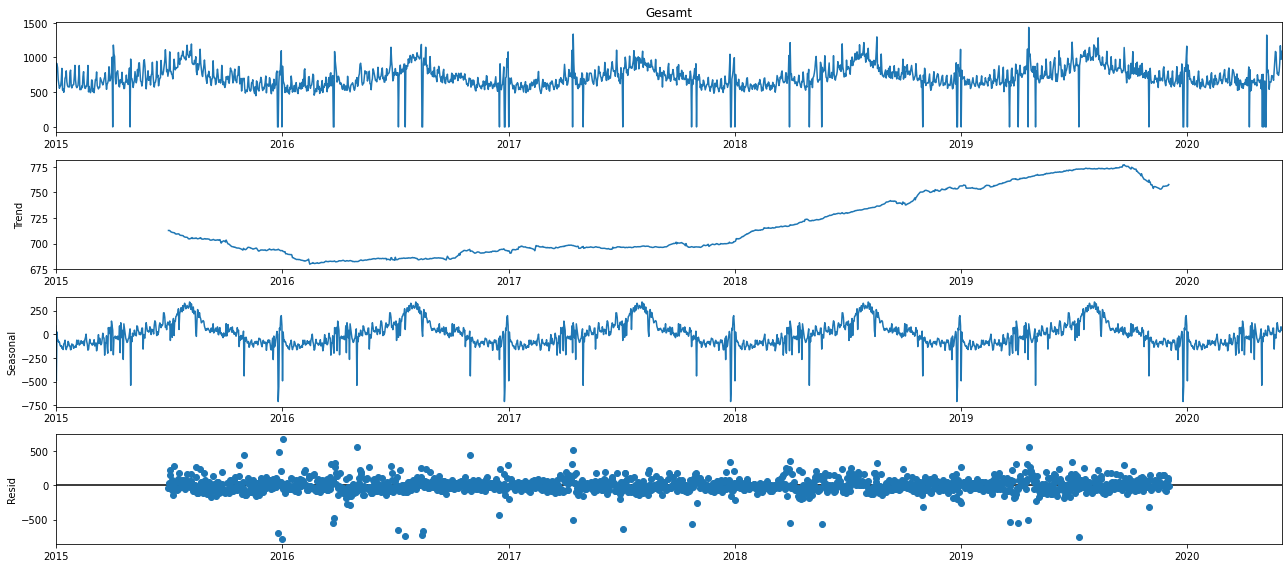

In [356]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Gesamt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

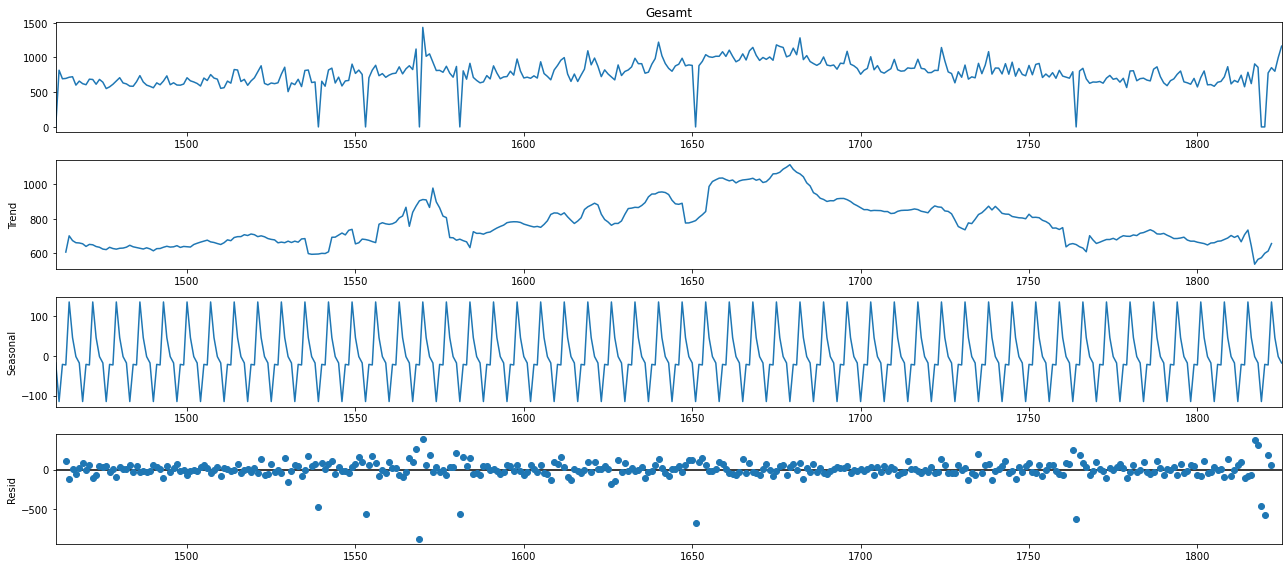

In [357]:
Jahr = 2019
#for idx,fil in enumerate([df_new_1,df_new_2,df_new_3],1):
y = df_new_2[df_newmodel_2.index.year == Jahr].Gesamt
#sum(axis=1)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

### Analysis on Articlegroups

#### Weizenbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases over the years.`
-  `There is a weekly and yearly saisonality.`

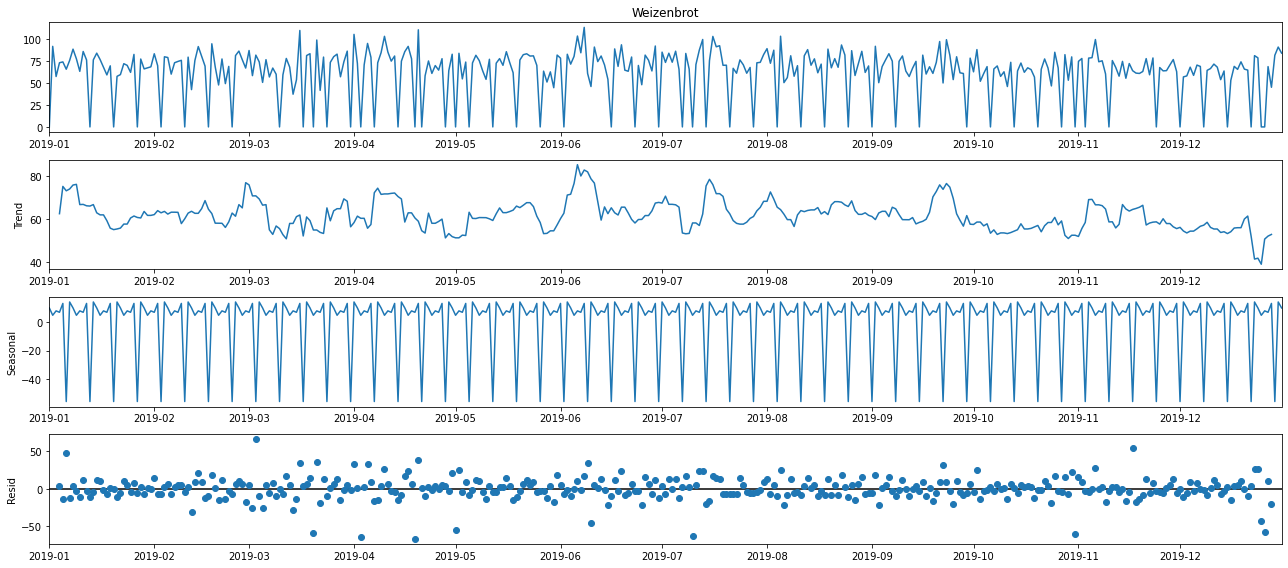

In [358]:
Jahr = 2019
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year == Jahr].Weizenbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

#### Mischbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly and yearly saisonality.`

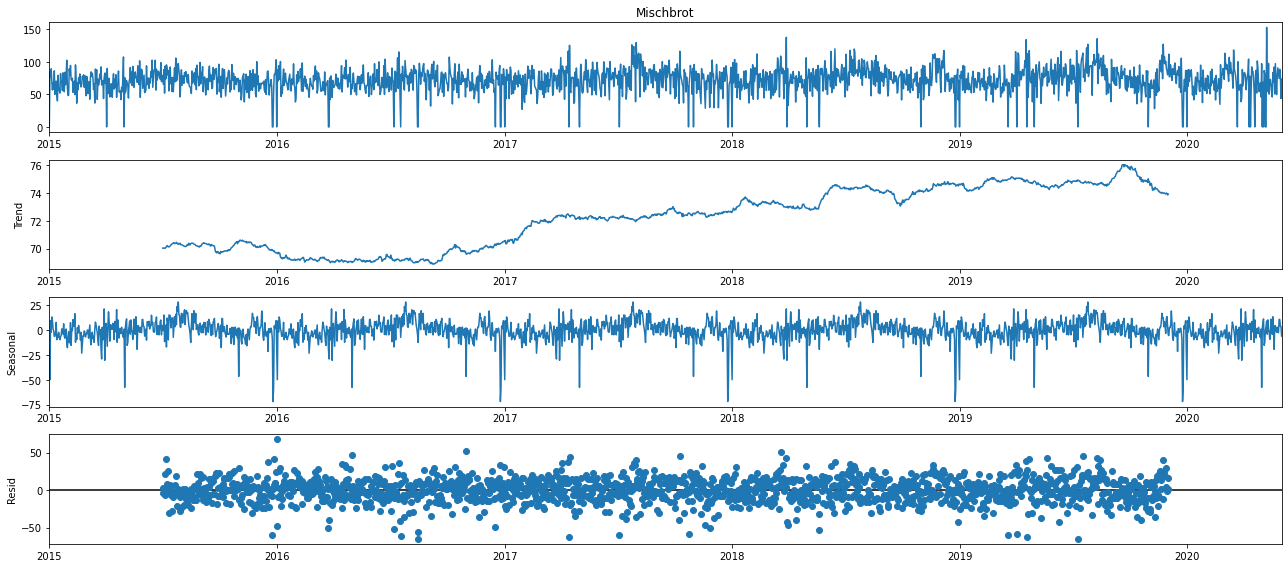

In [359]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Mischbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Vollkornbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly saisonality which means period=7.`

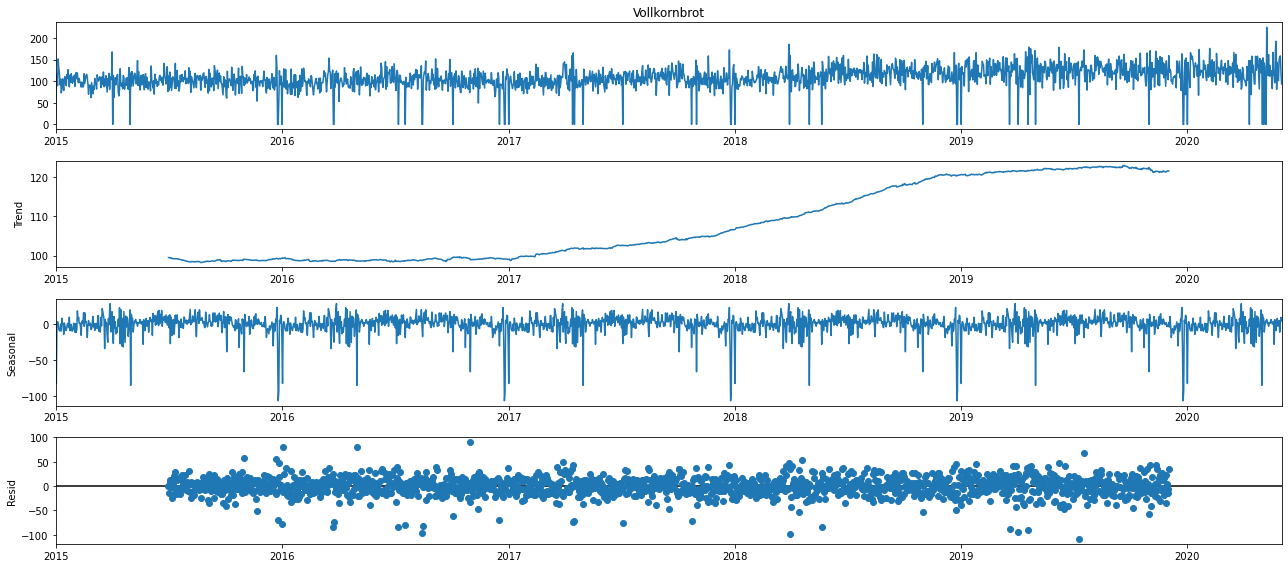

In [360]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Vollkornbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Spezialbrot

**Conclusions**
- `After the launch of the product in 2016 the sales volumne is relativly contant over the years.`
- `There is a weekly and yearly saisonality.`

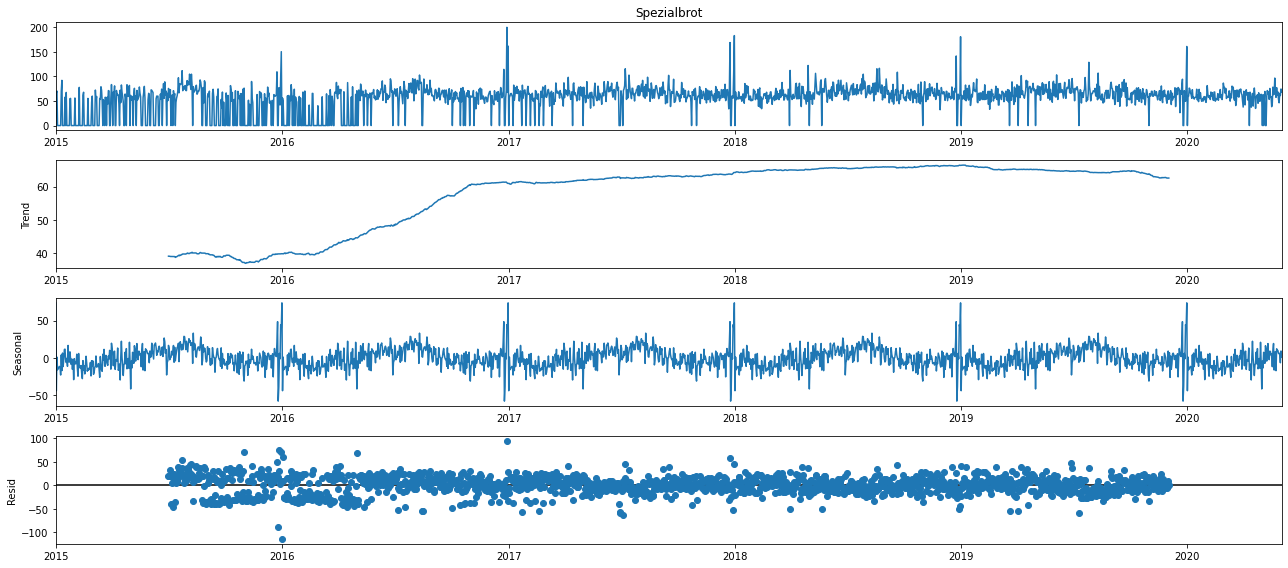

In [361]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Spezialbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stangenbrot

**Conclusions**
- `The is a trend which can be seen for period=365. The sales volumne first increases until 2018 and than increase.`
- `There is a weekly and yearly saisonality.`

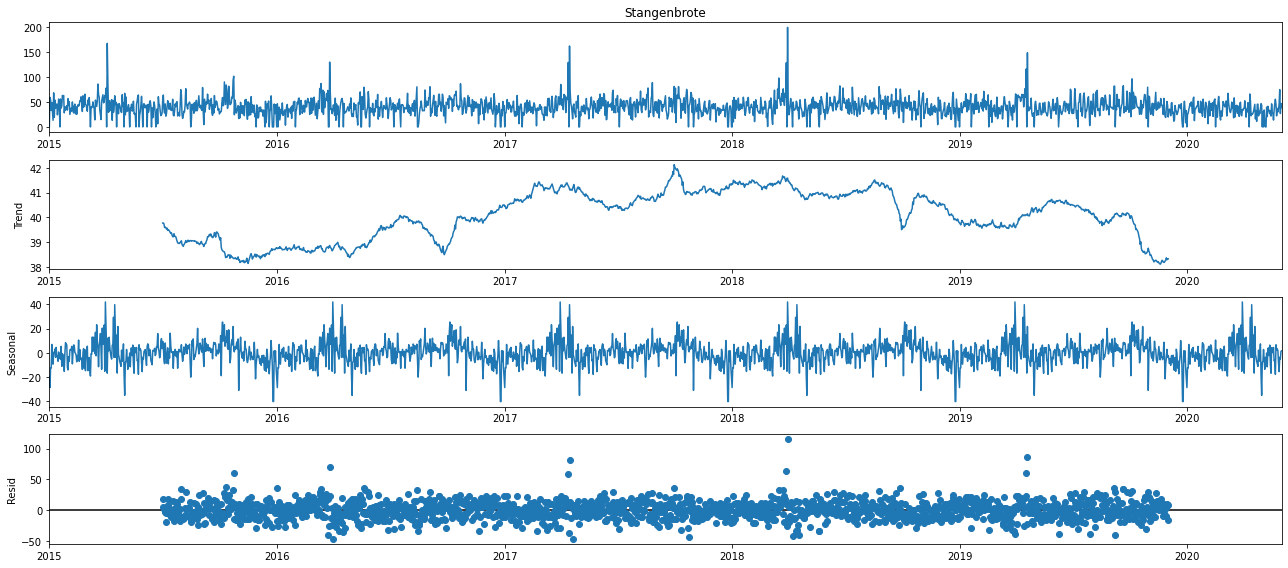

In [48]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Stangenbrote

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years.`
- `There is a weekly saisonality which means period=7.`

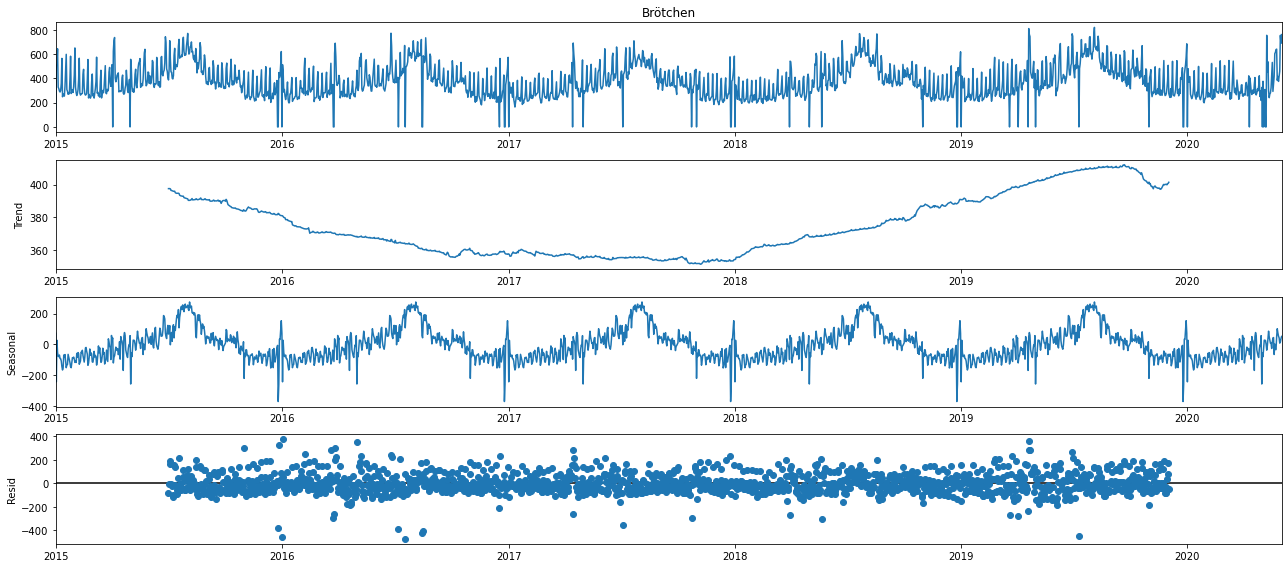

In [49]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Süsse Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroup Brötchen.`
- `There are weekly and yearly patterns.`

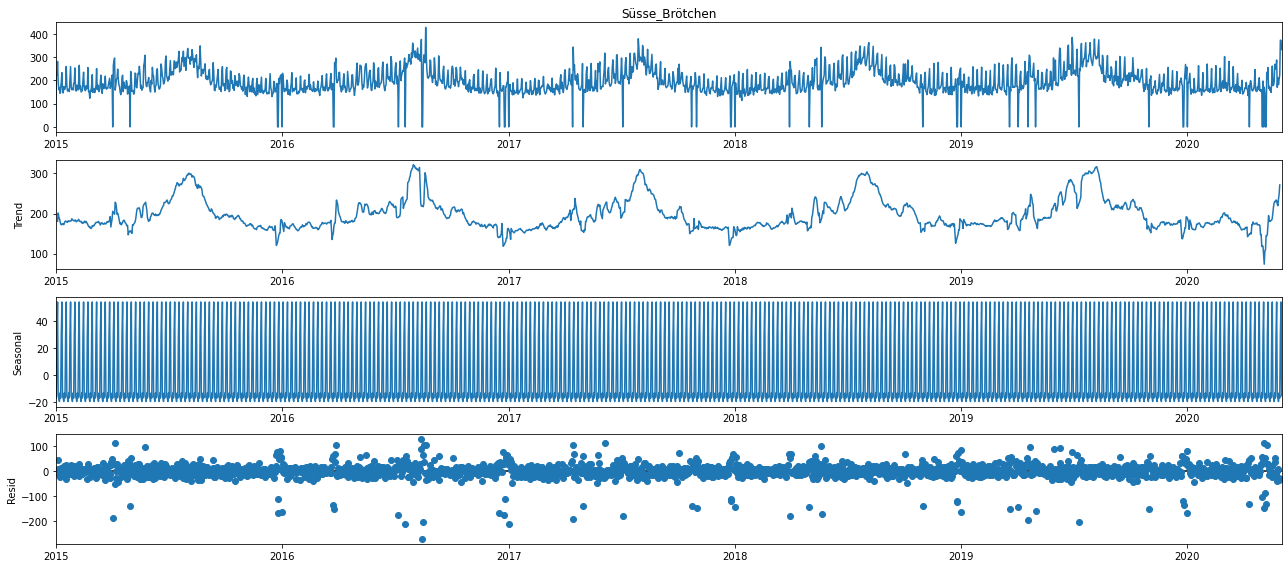

In [50]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Süsse_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

#### Herzhafte Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.

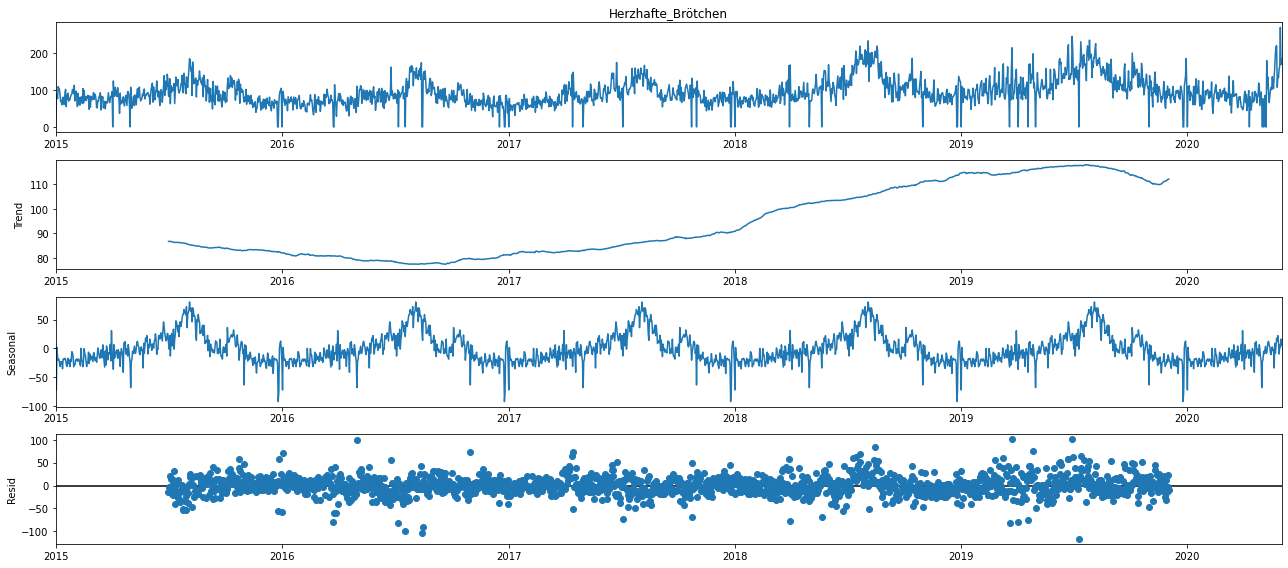

In [51]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Herzhafte_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### KonditoreiBlech

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases since 2017. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.`
-`There are weekly and yearly patterns within the data.`


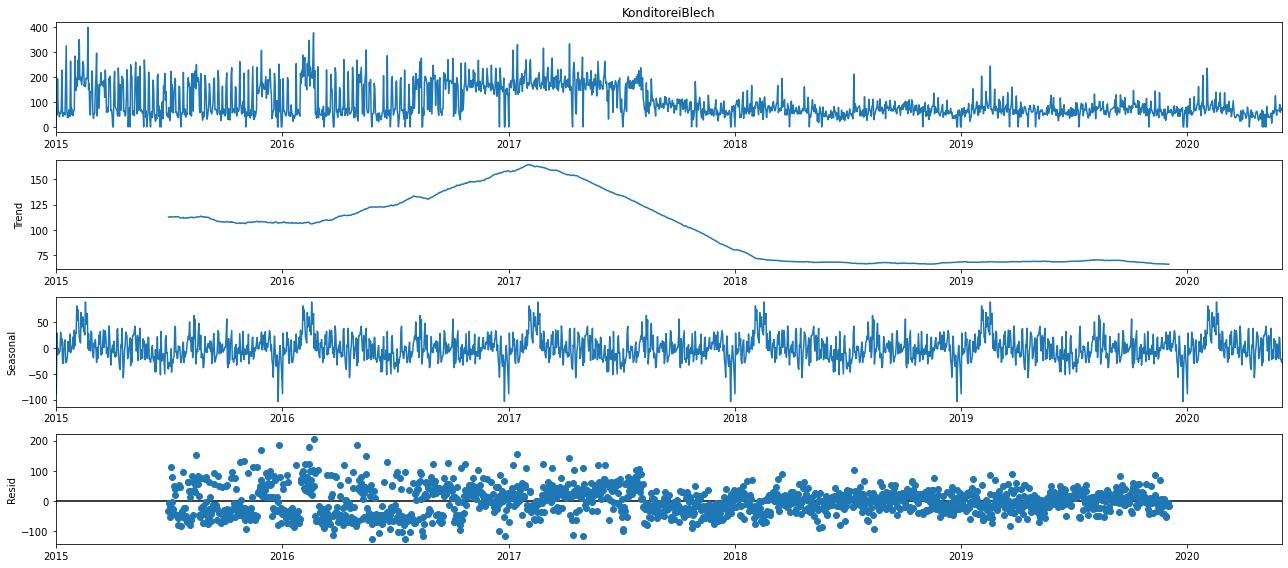

In [52]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].KonditoreiBlech

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stückgebäck

**Conclusions**

- `You can see peaks for every New Year's Eve. Inspite of this peaks, the values are rel. constant over the years.`
- `There are weak weekly and yearly patterns within the data.`


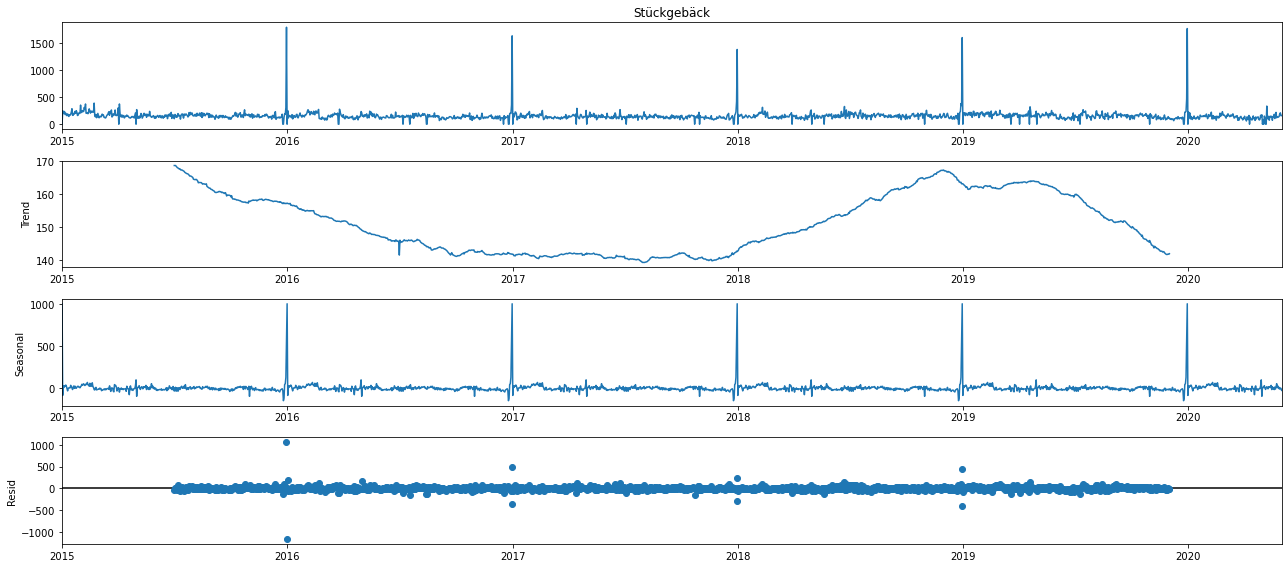

In [53]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Stückgebäck

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Blechkuchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2018.`
- `There are weekly and yearly patterns within the data.`


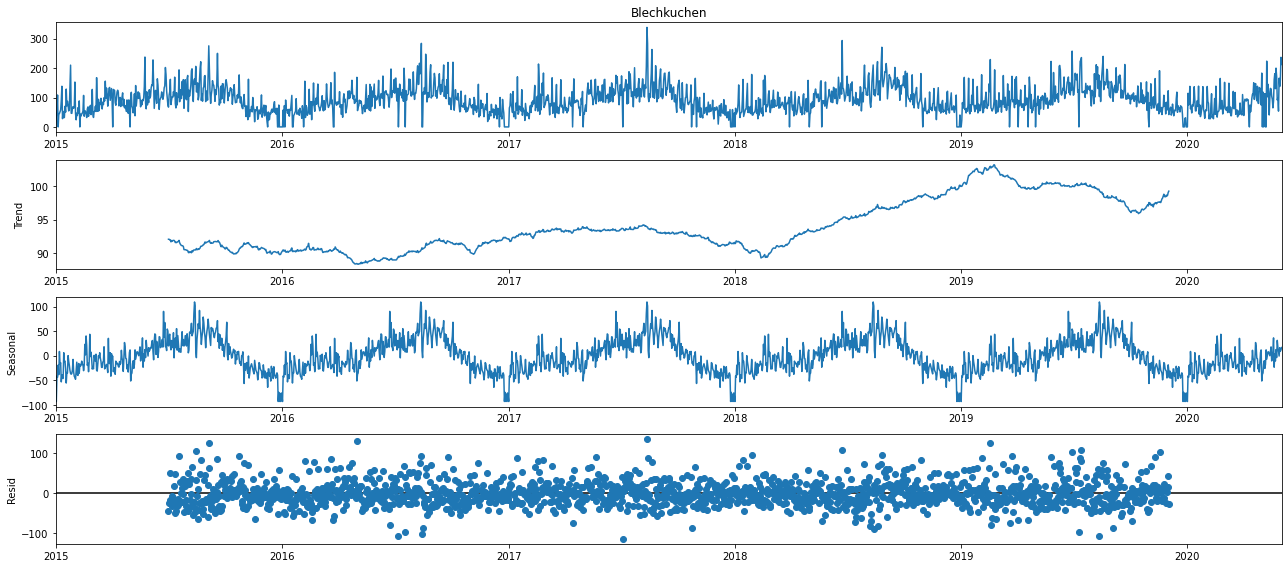

In [54]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Blechkuchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Weihnachtsartikel

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2017.`
- `There are hugh yearly patterns within the data, which does not surprise.`


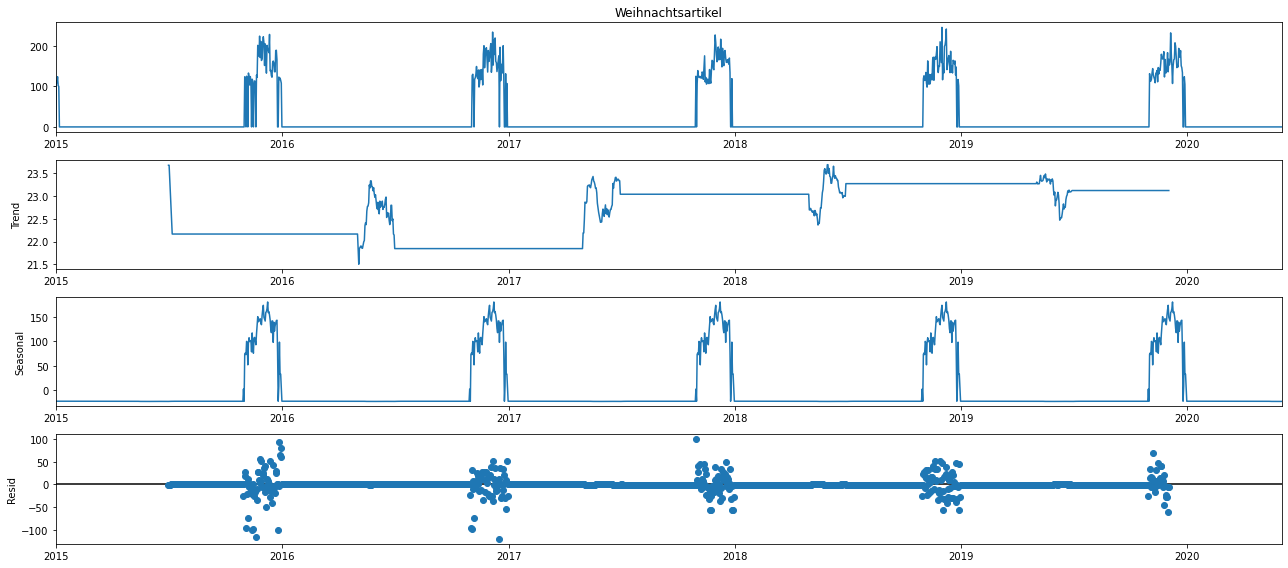

In [55]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Weihnachtsartikel

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

## Lag Plots

### Filiale 2

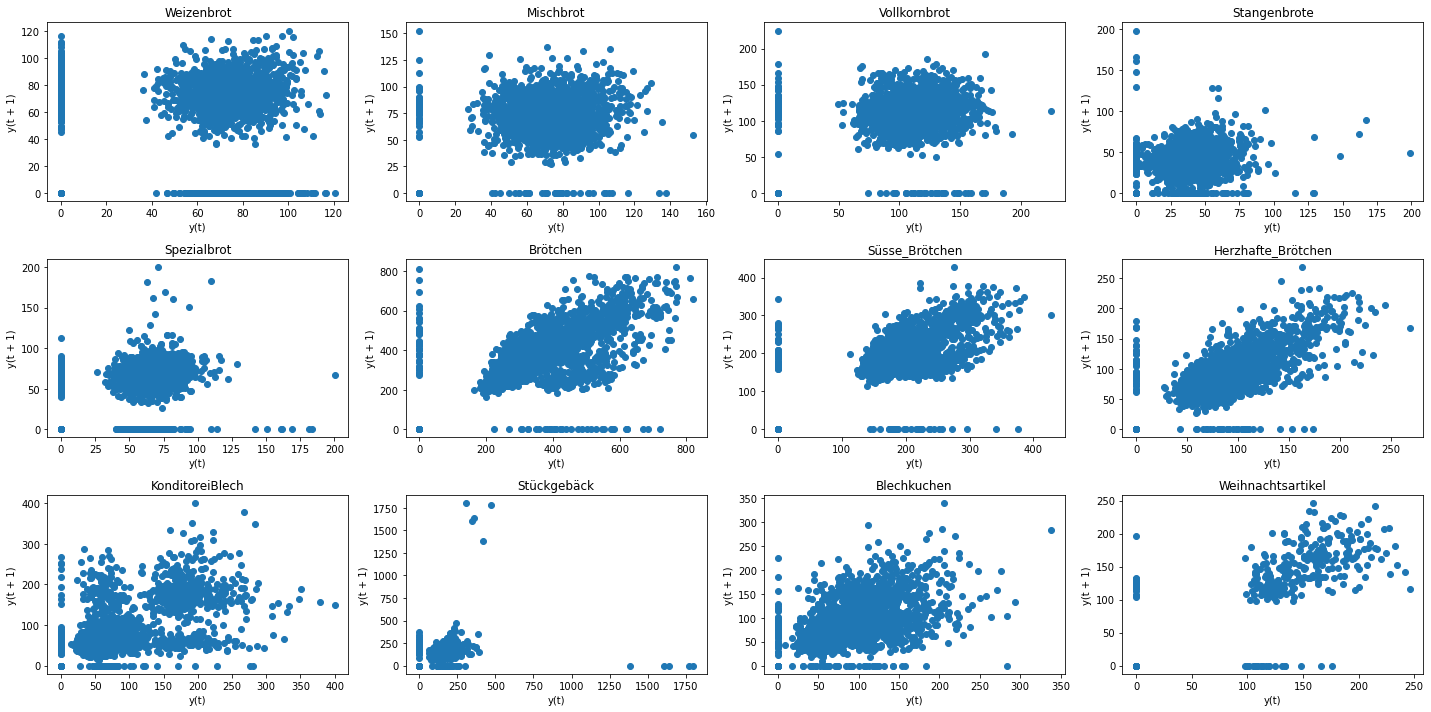

In [56]:
# Make the graph 20 inches by 10 inches
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    lag_plot(df_basis_2['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Autocorrelation Plots

### Before Corona

In [57]:

y_2_gesamt=df_newmodel_2.Gesamt[:'15.03.2020']


#### Filiale 2

**Conclusions**
- `From the plot you can see there is a high peak in correlation at the lag of 7th day, then again on the 14th day
and so on. The series is perfectly autocorrelated with a lag of 1 week.`
- `This is valid for all single articlegroups with the exception Weihnachtsartikel. See single plots.`
- `For all articlegroups except Brot(Vollkornbrot, Weizenbrot,..) you see a  peak in correlation at the lag of 365th day.`


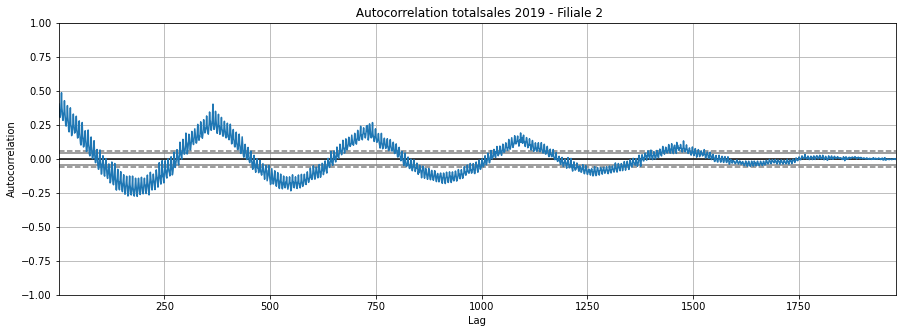

In [58]:
# Autocorrelation totalsales  - Filiale 2
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,5))
autocorrelation_plot(df_new_2.Gesamt).set_title(" Autocorrelation totalsales 2019 - Filiale 2")
plt.show()

In [59]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
#fig.suptitle('AC and PAC for Filiale 2')
#sm.graphics.tsa.plot_acf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax1)
#sm.graphics.tsa.plot_pacf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax2)
#plt.show()


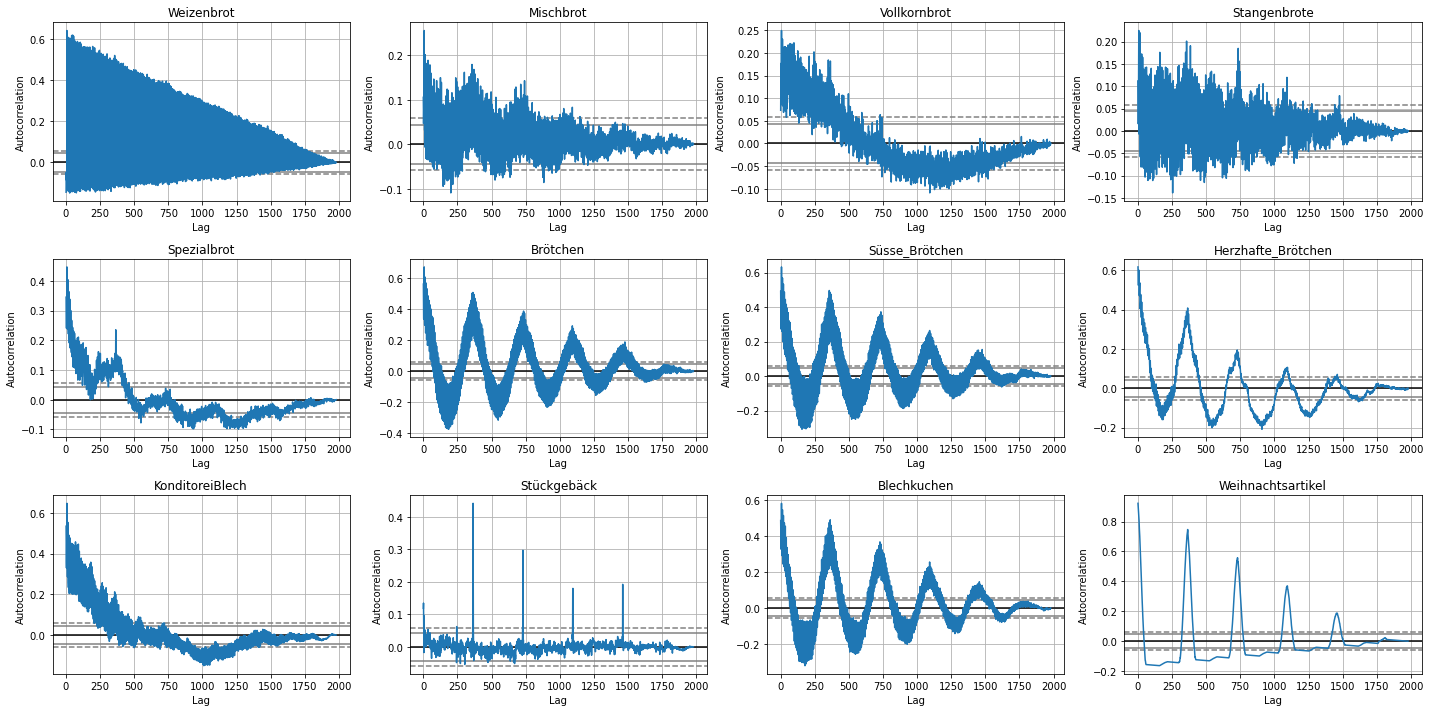

In [60]:
# Analyse weekly dependencies
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    autocorrelation_plot(df_basis_2['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

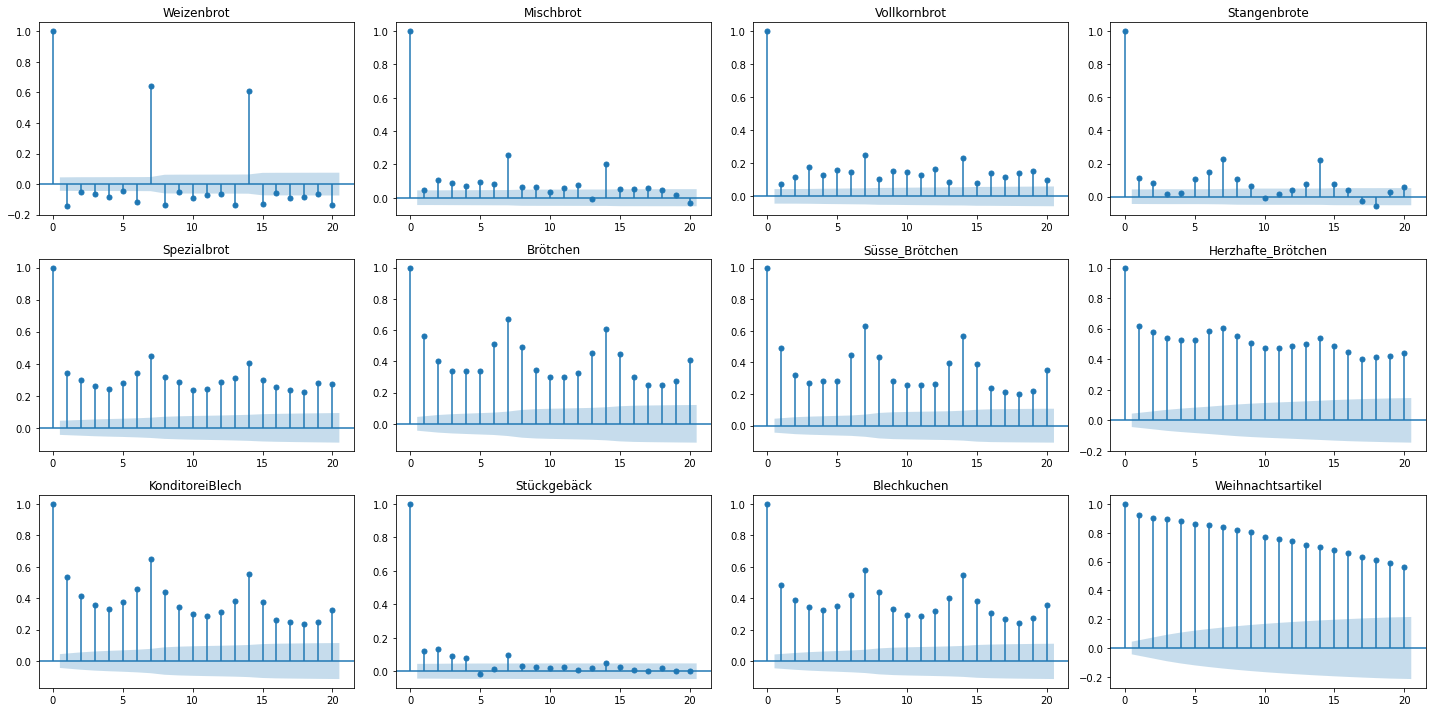

In [61]:
# Analyse weekly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_2['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

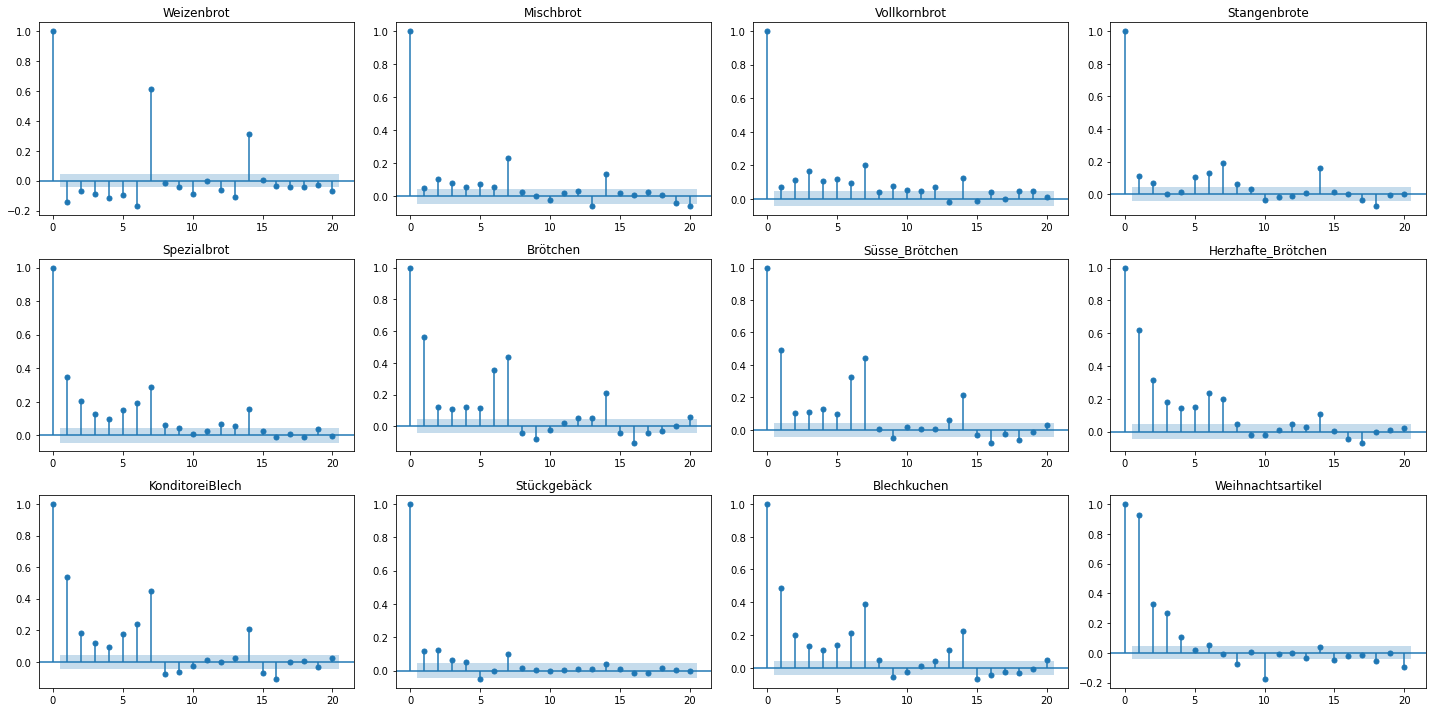

In [62]:
# Analyse weekly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_2['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

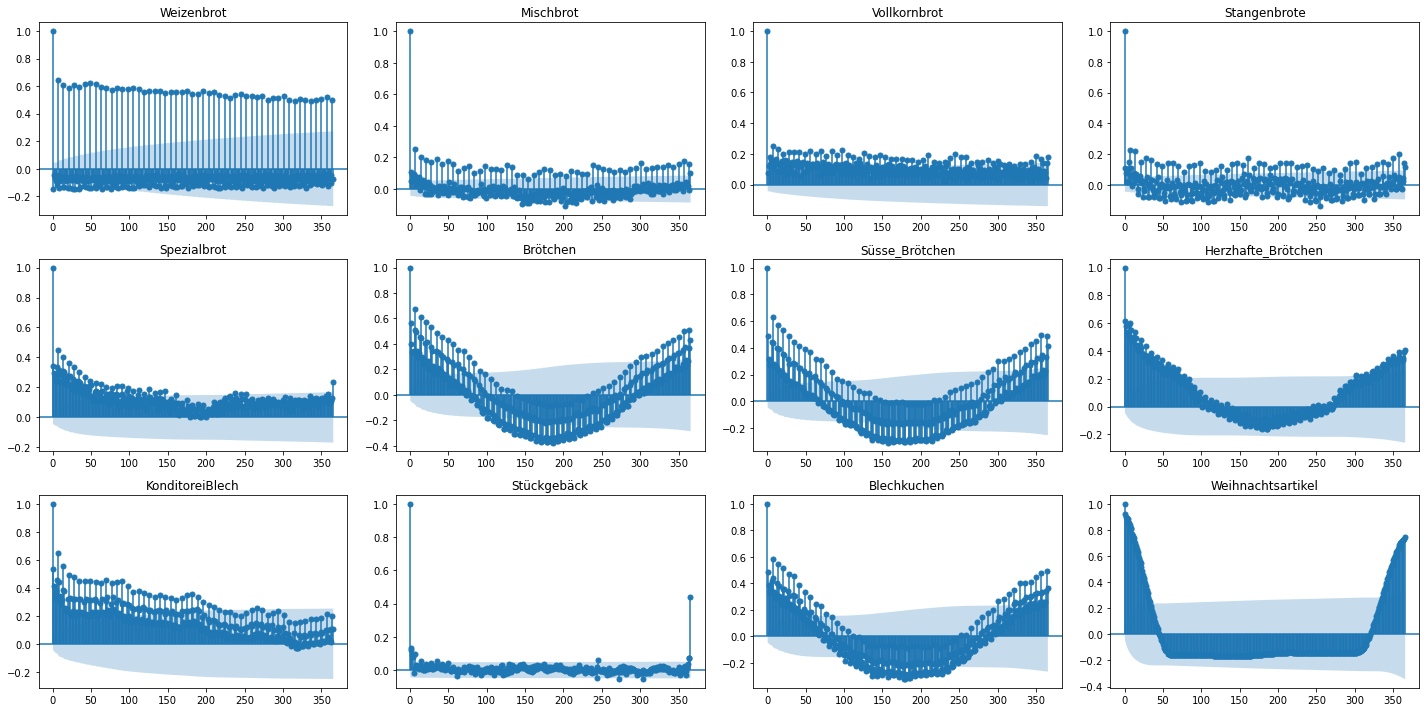

In [63]:
# Analyse yearly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_2['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

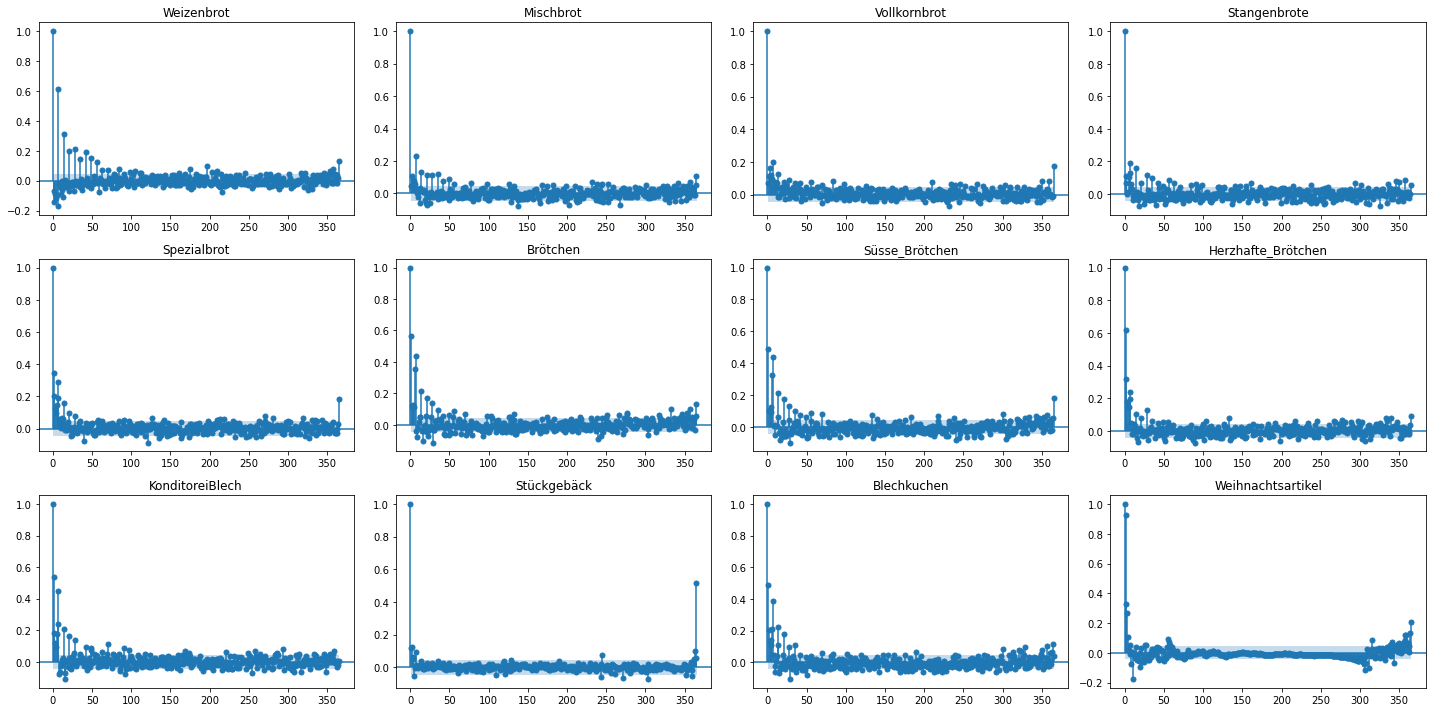

In [64]:
# Analyse yearly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_2['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

### Corona

**Conclusions**
- `The Sales cannot be predicted under the changing corona circumstances.So I decided to not predict sales with date after 15.03.2020.`

In [ ]:
y_corona=df_newmodel.Gesamt['01.03.2020':]


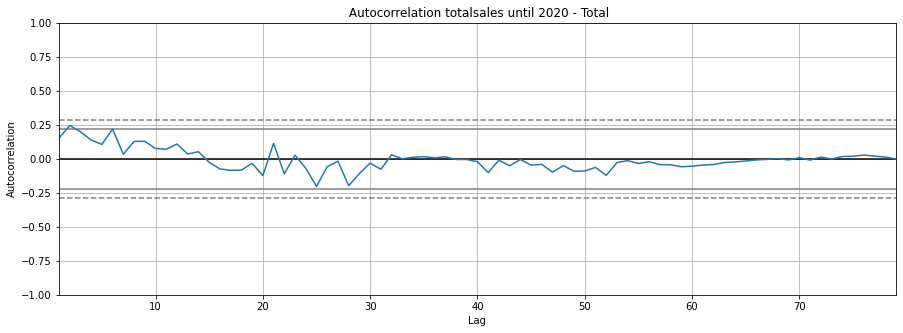

In [76]:
# Autocorrelation totalsales 2020
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,5))
autocorrelation_plot(df_newmodel_2.Gesamt['15.03.2020':]).set_title(" Autocorrelation totalsales until 2020 - Total")

plt.show()

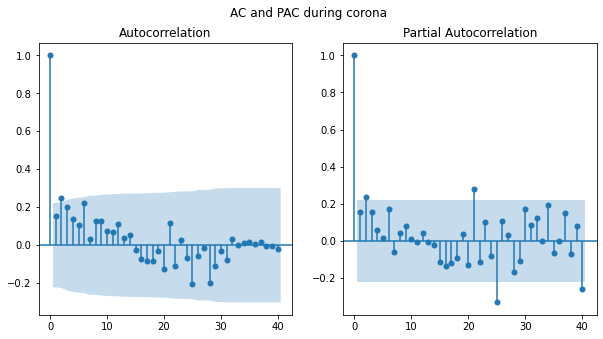

In [77]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('AC and PAC during corona')
sm.graphics.tsa.plot_acf(df_newmodel_2.Gesamt['15.03.2020':].squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_newmodel_2.Gesamt['15.03.2020':].squeeze(), lags=40, ax=ax2)
plt.show()

## Check Stationarity

**Conclusions**
- `None of the series is stationary. To use ARIMA or VARIMA/VARIMAX I need to use differencing the Series.`
- `This need to be done one or more times per series with the result that the series is  difference-stationary.`
- `The number of transformations which have to be done can be estimated via auto arima. See next section.`


In [66]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test short
from statsmodels.tsa.stattools import adfuller
def adf_test_long(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
     
    p = adf['p-value']
    if p <= signif:
        pass
        #print(f" Series is Stationary")
        
    else:
        print(f"Ergebnis für Timeseries {name}:")
        print (adf)
        print(f" Series is Non-Stationary")


In [67]:
def adf_test_long_einzel(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
     
    p = adf['p-value']
    if p <= signif:
        pass
        print(f" Series is Stationary")
        print (adf)
    else:
        print(f"Ergebnis für Timeseries:")
        print (adf)
        print(f" Series is Non-Stationary")


In [68]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    
    p = adf['p-value']
    if p <= signif:
        pass
        #print(f" Series is Stationary")
    else: 
        print(f"Ergebnis für Timeseries {name}: Series is Non-Stationary")
        #print (adf)
        
#apply adf test on the series

### Filiale 2

In [69]:
#Apply Check to timeseries of Filiale 1
for name in df_basis_2.columns:
    adf_test_long(df_basis_2[name])
    

Ergebnis für Timeseries Vollkornbrot:
Test Statistic            -2.300552
p-value                    0.171790
# Lags                    42.000000
# Observations          1936.000000
Critical Value (1%)       -3.433732
Critical Value (5%)       -2.863034
Critical Value (10%)      -2.567565
dtype: float64
 Series is Non-Stationary
Ergebnis für Timeseries KonditoreiBlech:
Test Statistic            -1.496015
p-value                    0.535482
# Lags                    98.000000
# Observations          1880.000000
Critical Value (1%)       -3.433833
Critical Value (5%)       -2.863079
Critical Value (10%)      -2.567589
dtype: float64
 Series is Non-Stationary
Ergebnis für Timeseries Stückgebäck:
Test Statistic            -1.922365
p-value                    0.321614
# Lags                   365.000000
# Observations          1613.000000
Critical Value (1%)       -3.434411
Critical Value (5%)       -2.863334
Critical Value (10%)      -2.567725
dtype: float64
 Series is Non-Stationary
Ergeb

In [70]:
#Apply Check to timeseries of Filiale 2
for name in df_basis_2.columns:
    adf_test(df_basis_2[name])
    

Ergebnis für Timeseries Vollkornbrot: Series is Non-Stationary
Ergebnis für Timeseries KonditoreiBlech: Series is Non-Stationary
Ergebnis für Timeseries Stückgebäck: Series is Non-Stationary
Ergebnis für Timeseries Weihnachtsartikel: Series is Non-Stationary


## Check Causality

**Conclusions**
- `Looking at the p-Values we can assume that almost all variables are interchangeably each user.`
- `Overall this justifies an multivariate approach for prediction.`

In [71]:
maxlag=12
test = 'ssr-chi2test'

def grangers_causality_matrix(X_train, variables,Filiale, test = 'ssr_chi2test', verbose=False):
   dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
   for c in dataset.columns:
    for r in dataset.index:
        test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values)
        dataset.loc[r,c] = min_p_value
        
    dataset.columns = [var + '_x_'+ Filiale for var in variables]
    dataset.index = [var + '_y' for var in variables]

    return dataset


In [72]:
df_basisnew_2=df_newmodel_2.iloc[:,0:12]

In [73]:
result_2=grangers_causality_matrix(df_basisnew_2, df_basisnew_2.columns,Filiale='Filiale_2')


## Cointegrationtest

In [74]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

### Filiale 2

In [75]:
cointegration_test(df_basisnew_2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Weizenbrot ::  1844.45   > 311.1288  =>   True
Mischbrot ::  1260.31   > 263.2603  =>   True
Vollkornbrot ::  971.21    > 219.4051  =>   True
Stangenbrote ::  744.93    > 179.5199  =>   True
Spezialbrot ::  569.33    > 143.6691  =>   True
Brötchen ::  405.24    > 111.7797  =>   True
Süsse_Brötchen ::  268.81    > 83.9383   =>   True
Herzhafte_Brötchen ::  174.84    > 60.0627   =>   True
KonditoreiBlech ::  86.02     > 40.1749   =>   True
Stückgebäck ::  43.49     > 24.2761   =>   True
Blechkuchen ::  19.22     > 12.3212   =>   True
Weihnachtsartikel ::  0.96      > 4.1296    =>   False


# Modelling

## Metrics

**Conclusions**
- `I choose MAE and MAPE as Performance Measures for my project.`

I would analyse the results from the different models via the two different metrics mean absolute error **MAE** which is available via Sklearn.metrics and via the metrics mean absolute percentage error called **MAPE**.

There is no inbuilt function in sci-kit learn, so i define a custom function to calculate this measure. I adjusted the commom measure in the way that i do not consider all closed days of a Filiale.


In [494]:
#calculate mean absolute forecast error which only take actual values unequal to zero in consideration
def mean_absolute_percentage_error_WZ(actual, predicted): 
    
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100


In [79]:
#calculate mean absolute percentage forecast error
def mean_absolute_percentage_error(actual, predicted): 
    
    nz_1=(actual==0)
    actual_nz=actual[nz_1==0]
    
    difference_nz=actual-predicted
    difference_nz.dropna()
    return np.mean(np.abs((difference_nz) / actual_nz)) * 100

## Test-/Train-Split

Split into train and test datasets to build the model on the training dataset and forecast using the test dataset. I decide to use the first 4 years for training and the period since 01.01.2019 for testing. 

In [80]:
# use past 4 years data to forecast the next 15 months until corona

start_train='01.01.2016'
end_train = '31.12.2018'
start_test='01.01.2019'
corona='15.03.2020'

In [81]:
# Basismodel
train_basis_2 = df_newmodel_2[:end_train].copy()
test_basis_2 = df_newmodel_2[end_train:corona].copy()

In [82]:
train_new_2 = df_newmodel_2[start_train:end_train].copy()
test_new_2 = df_newmodel_2[start_test:corona].copy()

## Baseline Model

The moving average value can also be used directly to make predictions as a naive model and baseline for further 
on analysis. The fit would has been better if trend and seasonality components of the time series have already been removed or adjusted for.

In [197]:
# moving average smoothing as a forecast model
from math import sqrt
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [307]:
df_results_Baseline = pd.DataFrame( 
                  columns=['Model', 'Label','MAE_BASELINE'])

In [129]:
df_results_Baseline= pd.read_csv("df_results_Baseline")
df_results_Baseline

Unnamed: 0     Model               Label  MAE_BASELINE
0            1  BASELINE          Weizenbrot     21.810966
1            2  BASELINE           Mischbrot     14.696344
2            3  BASELINE        Vollkornbrot     17.744443
3            4  BASELINE        Stangenbrote     16.508831
4            5  BASELINE         Spezialbrot     13.188681
5            6  BASELINE            Brötchen     77.563061
6            7  BASELINE      Süsse_Brötchen     32.109803
7            8  BASELINE  Herzhafte_Brötchen     18.289108
8            9  BASELINE     KonditoreiBlech     34.783809
9           10  BASELINE         Stückgebäck     36.841229
10          11  BASELINE         Blechkuchen     27.420724
11          12  BASELINE   Weihnachtsartikel      6.205920

In [ ]:
# Baseline als moving average via window=7
article_selection=df_newmodel_2.iloc[:,0:12].columns.tolist()
        
for X in  article_selection:   

    window = 7
    history = [X[i] for i in range(window)]  
    test = [X[i] for i in range(window, len(X))] 
    predictions = []
#walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = mean([history[i] for i in range(length-window,length)]) 
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        MAE=(mean_absolute_error(test, predictions))
        df_results_Baseline=df_results_Baseline.append({'Model' : 'BASELINE' , 'Label' : article, 'MAE_BASELINE' : MAE} , ignore_index=True)



In [313]:
X_6=df_new_2.Brötchen   
window = 7
history_6 = [X_6[i] for i in range(window)]  
test_6 = [X_6[i] for i in range(window, len(X_6))] 
predictions_6 = []
#walk forward over time steps in test
for t in range(len(test_6)):
      length = len(history_6)
      yhat = mean([history_6[i] for i in range(length-window,length)]) 
      obs = test_6[t]
      predictions_6.append(yhat)
      history_6.append(obs)
        

In [ ]:
mae_6=(mean_absolute_error(test_6, predictions_6))
#mpe_6=(mean_absolute_error_nz(test_6, predictions_6))
print('Ergebnis der Baseline for articlegroup Brötchen:')
print('Mean absolute Error MAE %.3f' % mae_6)
#print('Mean absolute percentage Error MAPE %.3f' % mpe_6)
# plot
plt.figure(figsize=(15,5))
pyplot.plot(test_6)
pyplot.plot(predictions_6, color='red') 
pyplot.show()
# zoom plot
plt.figure(figsize=(15,5))
pyplot.plot(test_6[:100]) 
pyplot.plot(predictions_6[:100], color='red') 
pyplot.show()

# SARIMA und SARIMAX

## SARIMA - Basismodell

### AUTOARIMA to find the best Parameterkombination

**Conclusions**
- `The best combination for articlegroup Brötchen is (1,0,3)x((1,0,1,7).`
- `The best combination für Süsse_Brötchen is .`

In [ ]:
train_basis_2.columns

### SARIMA Model

#### Summary of the results (MAE,MAPE)

In [83]:
df_results_Sarima = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [84]:
df_results_Sarima

Empty DataFrame
Columns: [Model, Label, MAE, MAPE]
Index: []

In [ ]:
df_results_Sarima.to_csv("df_results_Sarima")

#### Weizenbrot

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 0, 2)x(2, 0, [], 7)
model_autoarima_1 = auto_arima(train_basis_2['Weizenbrot'], seasonal=True,m=7)


In [85]:
# Model fit
sarima_basis_2_1 = sm.tsa.statespace.SARIMAX(train_basis_2['Weizenbrot'],order=(2,0,2),seasonal_order=((2, 0, 0, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [432]:
from sklearn.metrics import mean_squared_error
pred_basis_2_1 = sarima_basis_2_1.predict('01.01.2019','15.03.2020')[:]
MAE_1=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Weizenbrot'],pred_basis_2_1))
MAPE_1=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Weizenbrot'],pred_basis_2_1))
print('Results for Basismodel-Articlegroup Weizenbrot:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_1))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_1))

Results for Basismodel-Articlegroup Weizenbrot:
SARIMA model MAE: 48.99
SARIMA model MAPE: 76.33%


In [87]:
df_results_Sarima.loc['1',:] = ['SARIMA-BASIS','Weizenbrot',MAE_1,MAPE_1]

#### Mischbrot

In [88]:
#m = 7 as data contains daily observations SARIMAX(2, 0, 2)x(2, 0, [], 7)
model_autoarima_2 = auto_arima(train_basis_2['Mischbrot'], seasonal=True,m=7)


In [89]:
# Model fit
sarima_basis_2_2 = sm.tsa.statespace.SARIMAX(train_basis_2['Mischbrot'],order=(2,0,2),seasonal_order=((2, 0, 0, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [90]:
pred_basis_2_2 = sarima_basis_2_2.predict('01.01.2019','15.03.2020')[:]

MAE_2=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Mischbrot'],pred_basis_2_2))
MAPE_2=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Mischbrot'],pred_basis_2_2))
print('Results for Basismodel-Articlegroup Mischbrot:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_2))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_2))

df_results_Sarima.loc['2',:] = ['SARIMA-BASIS','Mischbrot',MAE_2,MAPE_2]

Results for Basismodel-Articlegroup Mischbrot:
SARIMA model MAE: 16.77
SARIMA model MAPE: 20.65%


#### Vollkornbrot

In [ ]:
#m = 7 as data contains daily observations SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)
model_autoarima_3 = auto_arima(train_basis_2['Vollkornbrot'], seasonal=True,m=7)


In [91]:
# Model fit
sarima_basis_2_3 = sm.tsa.statespace.SARIMAX(train_basis_2['Vollkornbrot'],order=(0,1,1),seasonal_order=((0, 0, 1, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [92]:
pred_basis_2_3 = sarima_basis_2_3.predict('01.01.2019','15.03.2020')[:]

MAE_3=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Vollkornbrot'],pred_basis_2_3))
MAPE_3=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Vollkornbrot'],pred_basis_2_3))
print('Results for Basismodel-Articlegroup Vollkornbrot:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_3))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_3))

df_results_Sarima.loc['3',:] = ['SARIMA-BASIS','Vollkornbrot',MAE_3,MAPE_3]

Results for Basismodel-Articlegroup Vollkornbrot:
SARIMA model MAE: 21.79
SARIMA model MAPE: 15.32%


#### Spezialbrot

In [ ]:
#m = 7 as data contains daily observations SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7) / SARIMAX(5, 1, 5)
model_autoarima_4 = auto_arima(train_basis_2['Spezialbrot'], seasonal=True,m=1)
#model_autoarima_4.summary()

In [93]:
# Model fit
sarima_basis_2_4 = sm.tsa.statespace.SARIMAX(train_basis_2['Spezialbrot'],order=(5,1,5),
                                             #seasonal_order=((2, 0, 1, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [94]:
pred_basis_2_4 = sarima_basis_2_4.predict('01.01.2019','15.03.2020')[:]

MAE_4=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Spezialbrot'],pred_basis_2_4))
MAPE_4=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Spezialbrot'],pred_basis_2_4))
print('Results for Basismodel-Articlegroup Spezialbrot:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_4))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_4))

df_results_Sarima.loc['4',:] = ['SARIMA-BASIS','Spezialbrot',MAE_4,MAPE_4]

Results for Basismodel-Articlegroup Spezialbrot:
SARIMA model MAE: 12.22
SARIMA model MAPE: 18.47%


#### Stangenbrote

In [ ]:
#m = 7 as data contains daily observations SARIMAX(1, 0, 0)x(1, 0, [1, 2], 7)
model_autoarima_5 = auto_arima(train_basis_2['Stangenbrote'], seasonal=True,m=1)
#model_autoarima_5.summary()

In [95]:
# Model fit
sarima_basis_2_5 = sm.tsa.statespace.SARIMAX(train_basis_2['Stangenbrote'],order=(1,0,0),seasonal_order=((1, 0, 1, 7)),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

In [96]:
pred_basis_2_5= sarima_basis_2_5.predict('01.01.2019','15.03.2020')[:]

MAE_5=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Stangenbrote'],pred_basis_2_5))
MAPE_5=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Stangenbrote'],pred_basis_2_5))
print('Results for Basismodel-Articlegroup Stangenbrote:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_5))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_5))

df_results_Sarima.loc['5',:] = ['SARIMA-BASIS','Stangenbrote',MAE_5,MAPE_5]

Results for Basismodel-Articlegroup Stangenbrote:
SARIMA model MAE: 11.86
SARIMA model MAPE: 35.24%


#### Brötchen

In [972]:
#m = 7 as data contains daily observations SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)
model_autoarima_6 = auto_arima(train_basis_2['Brötchen'], seasonal=False,m=0)
model_autoarima_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1461
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -8823.309
Date:                Fri, 13 Nov 2020   AIC                          17656.617
Time:                        17:44:58   BIC                          17683.052
Sample:                             0   HQIC                         17666.478
                               - 1461                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.1252      1.860      2.756      0.006       1.481       8.770
ar.L1          0.9859      0.005    186.572      0.000       0.976       0.996
ma.L1         -0.6096      0.018    -34.456      0.000      -0.644      -0.575
ma.L2         -0.2535      0.020    -12.865      0.000      -0.292      -0.215
sigma2      1.038e+04    248.982     41.695      0.000    9893.390    1.09e+04
===================================================================================
Ljung-Box (Q):                     1499.41   Jarque-Bera (JB):              1123.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.28
Prob(H) (two-sided):                  0.14   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [968]:
# Model fit
sarima_basis_2_6 = sm.tsa.statespace.SARIMAX(train_basis_2['Brötchen'],order=(1,0,3),seasonal_order=(2,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_6.summary()

In [969]:
pred_basis_2_6 = sarima_basis_2_6.predict('01.01.2019','15.03.2020')[:]

MAE_6=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Brötchen'],pred_basis_2_6))
MAPE_6=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Brötchen'],pred_basis_2_6))
print('Results for Basismodel-Articlegroup Brötchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_6))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_6))

df_results_Sarima.loc['6',:] = ['SARIMA-BASIS','Brötchen',MAE_6,MAPE_6]

Results for Basismodel-Articlegroup Brötchen:
SARIMA model MAE: 107.76
SARIMA model MAPE: 22.64%


#### Süsse_Brötchen

In [ ]:
#m = 7 as data contains daily observations SARIMAX(3, 0, 0)x(2, 0, [1], 7)
model_autoarima_7 = auto_arima(train_basis_2['Süsse_Brötchen'], seasonal=True,m=7)


In [99]:
# Model fit
sarima_basis_2_7 = sm.tsa.statespace.SARIMAX(train_basis_2['Süsse_Brötchen'],order=(1,0,3),seasonal_order=(1,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_7.summary()

In [100]:
pred_basis_2_7 = sarima_basis_2_7.predict('01.01.2019','15.03.2020')[:]

MAE_7=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Süsse_Brötchen'],pred_basis_2_7))
MAPE_7=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Süsse_Brötchen'],pred_basis_2_7))
print('Results for Basismodel-Articlegroup Süsse_Brötchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_7))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_7))

df_results_Sarima.loc['7',:] = ['SARIMA-BASIS','Süsse_Brötchen',MAE_7,MAPE_7]

Results for Basismodel-Articlegroup Süsse_Brötchen:
SARIMA model MAE: 41.21
SARIMA model MAPE: 17.16%


#### Herzhafte Brötchen

In [ ]:
#m = 7 as data contains daily observations SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)
model_autoarima_8 = auto_arima(train_basis_2['Herzhafte_Brötchen'], seasonal=True,m=7)


In [101]:
# Model fit
sarima_basis_2_8 = sm.tsa.statespace.SARIMAX(train_basis_2['Herzhafte_Brötchen'],order=(0,1,1),seasonal_order=(0,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_8.summary()

In [102]:
pred_basis_2_8 = sarima_basis_2_8.predict('01.01.2019','15.03.2020')[:]

MAE_8=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Herzhafte_Brötchen'],pred_basis_2_8))
MAPE_8=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Herzhafte_Brötchen'],pred_basis_2_8))
print('Results for Basismodel-Articlegroup Herzhafte_Brötchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_8))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_8))

df_results_Sarima.loc['8',:] = ['SARIMA-BASIS','Herzhafte_Brötchen',MAE_8,MAPE_8]

Results for Basismodel-Articlegroup Herzhafte_Brötchen:
SARIMA model MAE: 30.68
SARIMA model MAPE: 24.75%


#### KonditoreiBlech

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 1, 2)x(2, 0, 2, 7)	
model_autoarima_9 = auto_arima(train_basis_2['KonditoreiBlech'], seasonal=True,m=7)

In [103]:
# Model fit
sarima_basis_2_9 = sm.tsa.statespace.SARIMAX(train_basis_2['KonditoreiBlech'],order=(2,1,2),seasonal_order=(2,0,2,7),
                                enforce_stationarity=True, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_9.summary()

In [104]:
pred_basis_2_9 = sarima_basis_2_9.predict('01.01.2019','15.03.2020')[:]

MAE_9=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['KonditoreiBlech'],pred_basis_2_9))
MAPE_9=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['KonditoreiBlech'],pred_basis_2_9))
print('Results for Basismodel-Articlegroup KonditoreiBlech:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_9))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_9))

df_results_Sarima.loc['9',:] = ['SARIMA-BASIS','KonditoreiBlech',MAE_9,MAPE_9]

Results for Basismodel-Articlegroup KonditoreiBlech:
SARIMA model MAE: 99.85
SARIMA model MAPE: 143.86%


#### Stückgebäck

In [ ]:
#m = 7 as data contains daily observations SARIMAX(1, 1, 1)
model_autoarima_10 = auto_arima(train_basis_2['Stückgebäck'], seasonal=True,m=1)


In [105]:
# Model fit
sarima_basis_2_10 = sm.tsa.statespace.SARIMAX(train_basis_2['Stückgebäck'],order=(1,1,1),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_10.summary()

In [106]:
pred_basis_2_10 = sarima_basis_2_10.predict('01.01.2019','15.03.2020')[:]

MAE_10=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Stückgebäck'],pred_basis_2_10))
MAPE_10=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Stückgebäck'],pred_basis_2_10))
print('Results for Basismodel-Articlegroup Stückgebäck:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_10))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_10))

df_results_Sarima.loc['10',:] = ['SARIMA-BASIS','Stückgebäck',MAE_10,MAPE_10]

Results for Basismodel-Articlegroup Stückgebäck:
SARIMA model MAE: 47.09
SARIMA model MAPE: 31.91%


#### Blechkuchen

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 0, 2)x(1, 0, [1], 7)
model_autoarima_11 = auto_arima(train_basis_2['Blechkuchen'], seasonal=True,m=7)

In [ ]:
#model_autoarima_11.summary()

In [107]:
# Model fit
sarima_basis_2_11 = sm.tsa.statespace.SARIMAX(train_basis_2['Blechkuchen'],order=(2,0,2),seasonal_order=(1,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_11.summary()
pred_basis_2_11 = sarima_basis_2_11.predict('01.01.2019','15.03.2020')[:]

MAE_11=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Blechkuchen'],pred_basis_2_11))
MAPE_11=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Blechkuchen'],pred_basis_2_11))
print('Results for Basismodel-Articlegroup Blechkuchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_11))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_11))

df_results_Sarima.loc['11',:] = ['SARIMA-BASIS','Blechkuchen',MAE_11,MAPE_11]

Results for Basismodel-Articlegroup Blechkuchen:
SARIMA model MAE: 35.41
SARIMA model MAPE: 36.58%


#### Weihnachtsartikel

In [ ]:
#m = 7 as data contains daily observations SARIMAX(2, 1, 1)x(2, 0, [1, 2], 7)
model_autoarima_12 = auto_arima(train_basis_2['Weihnachtsartikel'], seasonal=True,m=1)

In [ ]:
#model_autoarima_12.summary()

In [108]:
# Model fit
sarima_basis_2_12 = sm.tsa.statespace.SARIMAX(train_basis_2['Weihnachtsartikel'],order=(2,1,1),
                                              #seasonal_order=(2,0,1,7),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_13.summary()

In [109]:
pred_basis_2_12 = sarima_basis_2_12.predict('01.01.2019','15.03.2020')[:]

MAE_12=(mean_absolute_error(test_basis_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],pred_basis_2_12))
MAPE_12=(mean_absolute_percentage_error(test_basis_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],pred_basis_2_12))
print('Results for Basismodel-Articlegroup Weihnachtsartikel:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_12))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_12))

df_results_Sarima.loc['12',:] = ['SARIMA-BASIS','Weihnachtsartikel',MAE_12,MAPE_12]

Results for Basismodel-Articlegroup Weihnachtsartikel:
SARIMA model MAE: 27.42
SARIMA model MAPE: 92.42%


### Diagnostics for Brötchen

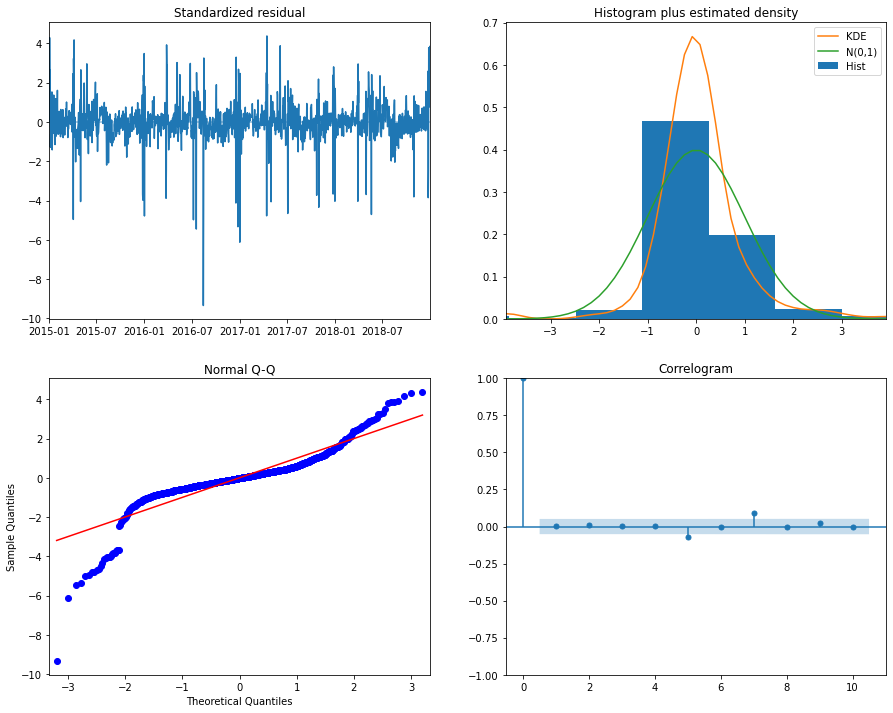

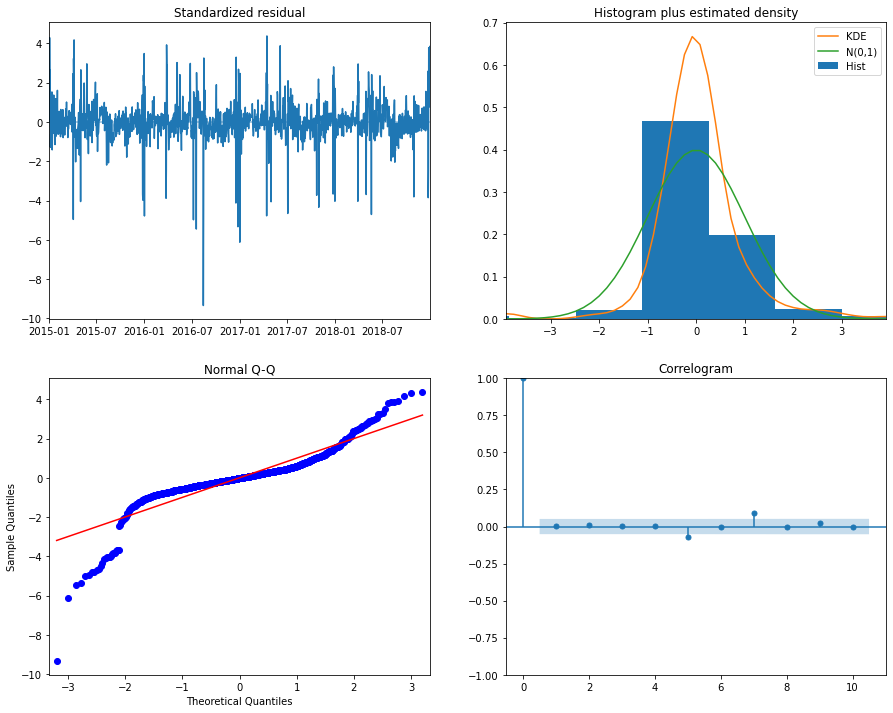

In [110]:
sarima_basis_2_6.plot_diagnostics(figsize=(15, 12))

## SARIMAX - New Model

### SARIMAX Model with exogenen Faktoren

In [111]:
exog_train_new_2=train_new_2.iloc[:,13:25]
exog_test_new_2=test_new_2.iloc[:,13:25]
#exog_test_new_2

#### Summary of the results (MAE, MAPE)

In [115]:
df_results_Sarimax = pd.DataFrame( 
                  columns=['Model', 'Label','MAE_NEW','MAPE_NEW'])

In [ ]:
df_results_Sarima= pd.read_csv("df_results_Sarima")

In [ ]:
df_vergleich=pd.merge(df_results_Sarimax,df_results_Sarima)
df_vergleich

In [ ]:
df_results_Sarimax.to_csv("df_results_Sarimax")

#### Weizenbrot

In [112]:
# Model fit
sarimax_new_2_1 = sm.tsa.statespace.SARIMAX(train_new_2['Weizenbrot'],order=(2,0,3),seasonal_order=(2,0,0,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_1.summary()

In [113]:
pred_new_2_1 = sarimax_new_2_1.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [116]:
MAE_1n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Weizenbrot'],pred_new_2_1.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_1n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Weizenbrot'],pred_new_2_1.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Weizenbrot:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_1n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_1n))

df_results_Sarimax.loc['1',:] = ['SARIMA-BASIS','Weizenbrot',MAE_1n,MAPE_1n]

Results for Basismodel-Articlegroup Weizenbrot:
SARIMAX model MAE: 16.94
SARIMAX model MAPE: 19.15%


#### Mischbrot

In [ ]:
# Model fit
sarimax_new_2_2 = sm.tsa.statespace.SARIMAX(train_new_2['Mischbrot'],order=(2,0,2),seasonal_order=(2,0,0,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_2.summary()

In [ ]:
pred_new_2_2 = sarimax_new_2_2.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [338]:
MAE_2n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Mischbrot'],pred_new_2_2.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_2n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Mischbrot'],pred_new_2_2.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Mischbrot:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_2n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_2n))

df_results_Sarimax.loc['2',:] = ['SARIMA-BASIS','Mischbrot',MAE_2n,MAPE_2n]

Results for Basismodel-Articlegroup Mischbrot:
SARIMAX model MAE: 13.14
SARIMAX model MAPE: 18.39%


#### Vollkornbrot

In [ ]:
# Model fit
sarimax_new_2_3 = sm.tsa.statespace.SARIMAX(train_new_2['Vollkornbrot'],order=(1,0,3),seasonal_order=(1,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_3.summary()

In [ ]:
pred_new_2_3 = sarimax_new_2_3.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [339]:
MAE_3n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Vollkornbrot'],pred_new_2_3.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_3n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Vollkornbrot'],pred_new_2_3.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Vollkornbrot:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_3n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_3n))

df_results_Sarimax.loc['3',:] = ['SARIMA-BASIS','Vollkornbrot',MAE_3n,MAPE_3n]

Results for Basismodel-Articlegroup Vollkornbrot:
SARIMAX model MAE: 17.10
SARIMAX model MAPE: 13.68%


#### Spezialbrot

In [340]:
# Model fit
sarimax_new_2_4 = sm.tsa.statespace.SARIMAX(train_new_2['Spezialbrot'],order=(1,1,0),seasonal_order=(2, 0, 1, 7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_4.summary()

pred_new_2_4 = sarimax_new_2_4.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_4n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Spezialbrot'],pred_new_2_4.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_4n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Spezialbrot'],pred_new_2_4.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Spezialbrot:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_4n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_4n))

df_results_Sarimax.loc['4',:] = ['SARIMA-BASIS','Spezialbrot',MAE_4n,MAPE_4n]

Results for Basismodel-Articlegroup Spezialbrot:
SARIMAX model MAE: 20.49
SARIMAX model MAPE: 34.45%


#### Stangenbrote

In [341]:
# Model fit
sarimax_new_2_5 = sm.tsa.statespace.SARIMAX(train_new_2['Stangenbrote'],order=(1,0,1),seasonal_order=((1, 1, 1, 7)),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_5.summary()

pred_new_2_5 = sarimax_new_2_5.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_5n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Stangenbrote'],pred_new_2_5.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_5n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Stangenbrote'],pred_new_2_5.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Stangenbrote:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_5n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_5n))

df_results_Sarimax.loc['5',:] = ['SARIMA-BASIS','Stangenbrote',MAE_5n,MAPE_5n]

Results for Basismodel-Articlegroup Stangenbrote:
SARIMAX model MAE: 11.95
SARIMAX model MAPE: 40.28%


#### Brötchen

In [ ]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(train_new_2['Brötchen'], exogenous=exog_train_new_2,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=7, max_q=7, m=7,
                           start_P=0, seasonal=True,
                            D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

#sxmodel.summary()

In [117]:
# Model fit
sarimax_new_2_6 = sm.tsa.statespace.SARIMAX(train_new_2['Brötchen'],order=(2,0,3),seasonal_order=(2,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_6.summary()

In [118]:
pred_new_2_6 = sarimax_new_2_6.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [119]:
MAE_6n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Brötchen'],pred_new_2_6.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_6n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Brötchen'],pred_new_2_6.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Brötchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_6n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_6n))

df_results_Sarimax.loc['6',:] = ['SARIMA-BASIS','Brötchen',MAE_6n,MAPE_6n]

Results for Basismodel-Articlegroup Brötchen:
SARIMAX model MAE: 78.62
SARIMAX model MAPE: 18.87%


In [ ]:
#pred_new_2_6_dyn = sarimax_new_2_6.get_prediction(dynamic='2019-01-01')

#### Süsse Brötchen

In [344]:
# Model fit
sarimax_new_2_7 = sm.tsa.statespace.SARIMAX(train_new_2['Süsse_Brötchen'],order=(3,0,0),seasonal_order=(2,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_7.summary()

pred_new_2_7 = sarimax_new_2_7.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_7n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Süsse_Brötchen'],pred_new_2_7.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_7n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Süsse_Brötchen'],pred_new_2_7.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Süsse_Brötchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_7n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_7n))

df_results_Sarimax.loc['7',:] = ['SARIMA-BASIS','SüsseBrötchen',MAE_7n,MAPE_7n]

Results for Basismodel-Articlegroup Süsse_Brötchen:
SARIMAX model MAE: 28.23
SARIMAX model MAPE: 12.77%


#### Herzhafte Brötchen

In [ ]:
# Model fit
sarimax_new_2_8 = sm.tsa.statespace.SARIMAX(train_new_2['Herzhafte_Brötchen'],order=(3,0,0),seasonal_order=(2,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_8.summary()

In [345]:
pred_new_2_8 = sarimax_new_2_8.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_8n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Herzhafte_Brötchen'],pred_new_2_8.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_8n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Herzhafte_Brötchen'],pred_new_2_8.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Herzhafte_Brötchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_8n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_8n))

df_results_Sarimax.loc['8',:] = ['SARIMA-BASIS','Herzhafte_Brötchen',MAE_8n,MAPE_8n]

Results for Basismodel-Articlegroup Herzhafte_Brötchen:
SARIMAX model MAE: 28.90
SARIMAX model MAPE: 22.98%


#### KonditoreiBlech

In [346]:
# Model fit
sarimax_new_2_9 = sm.tsa.statespace.SARIMAX(train_new_2['KonditoreiBlech'],order=(2,1,2),seasonal_order=(2,0,2,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_9.summary()

pred_new_2_9 = sarimax_new_2_9.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_9n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['KonditoreiBlech'],pred_new_2_9.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_9n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['KonditoreiBlech'],pred_new_2_9.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup KonditoreiBlech:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_9n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_9n))

df_results_Sarimax.loc['9',:] = ['SARIMA-BASIS','KonditoreiBlech',MAE_9n,MAPE_9n]

Results for Basismodel-Articlegroup KonditoreiBlech:
SARIMAX model MAE: 36.09
SARIMAX model MAPE: 46.53%


#### Stückgebäck

In [347]:
# Model fit
sarimax_new_2_10 = sm.tsa.statespace.SARIMAX(train_new_2['Stückgebäck'],order=(1,0,0),
                                             #seasonal_order=(2,0,2,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_10.summary()

pred_new_2_10 = sarimax_new_2_10.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_10n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Stückgebäck'],pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_10n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Stückgebäck'],pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Stückgebäck:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_10n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_10n))

df_results_Sarimax.loc['10',:] = ['SARIMA-BASIS','Stückgebäck',MAE_10n,MAPE_10n]

Results for Basismodel-Articlegroup Stückgebäck:
SARIMAX model MAE: 41.71
SARIMAX model MAPE: 25.79%


#### Blechkuchen

In [ ]:
# Model fit
sarimax_new_2_11 = sm.tsa.statespace.SARIMAX(train_new_2['Blechkuchen'],order=(3,0,0),seasonal_order=(1,0,1,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_11.summary()

In [348]:
pred_new_2_11 = sarimax_new_2_11.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [349]:
MAE_11n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Blechkuchen'],pred_new_2_11.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_11n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Blechkuchen'],pred_new_2_11.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Blechkuchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_11n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_11n))

df_results_Sarimax.loc['11',:] = ['SARIMA-BASIS','Blechkuchen',MAE_11n,MAPE_11n]

Results for Basismodel-Articlegroup Blechkuchen:
SARIMAX model MAE: 33.93
SARIMAX model MAPE: 40.51%


#### Weihnachtsartikel

In [350]:
# Model fit
sarimax_new_2_12 = sm.tsa.statespace.SARIMAX(train_new_2['Weihnachtsartikel'],order=(1,1,1),
                                             #seasonal_order=(2,0,2,7),
                                             exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_12.summary()

pred_new_2_12 = sarimax_new_2_12.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

MAE_12n=(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_12n=(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Weihnachtsartikel:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_12n))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_12n))

df_results_Sarimax.loc['12',:] = ['SARIMA-BASIS','Weihnachtsartikel',MAE_12n,MAPE_12n]

Results for Basismodel-Articlegroup Weihnachtsartikel:
SARIMAX model MAE: 129.44
SARIMAX model MAPE: 19.87%


#### Adding shift(364) to cover yearly patterns

In [332]:
exog_train_adv_2=train_new_2.iloc[:,13:27]
exog_test_adv_2=test_new_2.iloc[:,13:27]

In [333]:
#exog_train_adv_2.info()

In [334]:
# Model fit
sarimax_adv_2_6 = sm.tsa.statespace.SARIMAX(train_new_2['Brötchen'],order=(1,0,3),seasonal_order=(1,0,1,7),
                                             exog = exog_train_adv_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_adv_2_6.summary()

In [335]:
pred_adv_2_6 = sarimax_adv_2_6.get_prediction(start=start_test,end=corona,exog = exog_test_adv_2)

In [336]:
print('Results for Basismodel-articlegroup Brötchen:')
print('SARIMA model MAE: {0:.2f}'.
      format(mean_absolute_error(test_new_2['01.01.2019':'15.03.2020']['Brötchen'],pred_adv_2_6.predicted_mean['01.01.2019':'15.03.2020'])))
print('SARIMA model MAPE: {0:.2f}%'.format(mean_absolute_percentage_error(test_new_2['01.01.2019':'15.03.2020']['Brötchen'],pred_adv_2_6.predicted_mean['01.01.2019':'15.03.2020'])))

Results for Basismodel-articlegroup Brötchen:
SARIMA model MAE: 75.54
SARIMA model MAPE: 18.57%


### Plotting

#### Vollkornbrot

In [ ]:
pd.DataFrame({'test':test_new_2['01.01.2019':'15.03.2020']['Vollkornbrot'],'pred':pred_new_2_2.predicted_mean['01.01.2019':'15.03.2020']}).plot();plt.show()

#### Brötchen

In [ ]:
pd.DataFrame({'test':test_new_2['01.01.2019':'15.03.2020']['Brötchen'],'pred':pred_new_2_6diff.predicted_mean['01.01.2019':'15.03.2020']}).plot();plt.show()

#### Stückgebäck

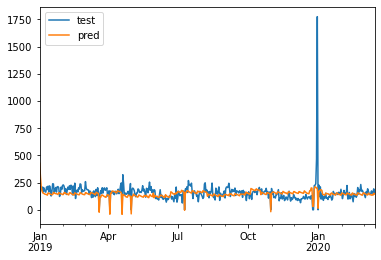

In [330]:
pd.DataFrame({'test':test_new_2['01.01.2019':'15.03.2020']['Stückgebäck'],'pred':pred_new_2_10.predicted_mean['01.01.2019':'15.03.2020']}).plot();plt.show()

#### Weihnachtsartikel

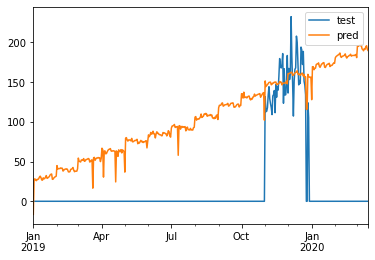

In [331]:
pd.DataFrame({'test':test_new_2['01.01.2019':'15.03.2020']['Weihnachtsartikel'],'pred':pred_new_2_12.predicted_mean['01.01.2019':'15.03.2020']}).plot();plt.show()

### Diagnostics

#### Diagnostics for Vollkornbrot

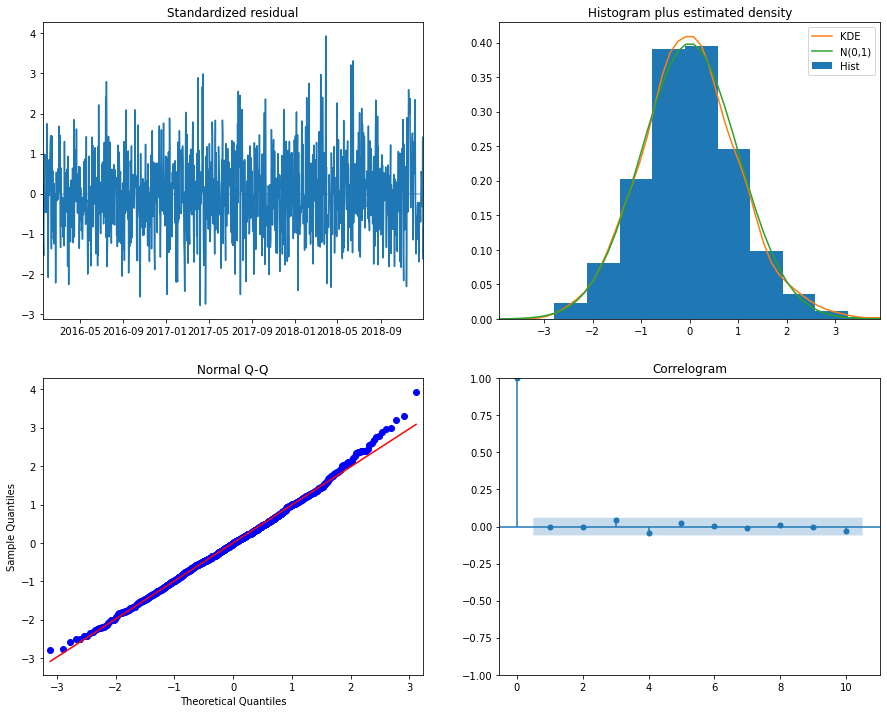

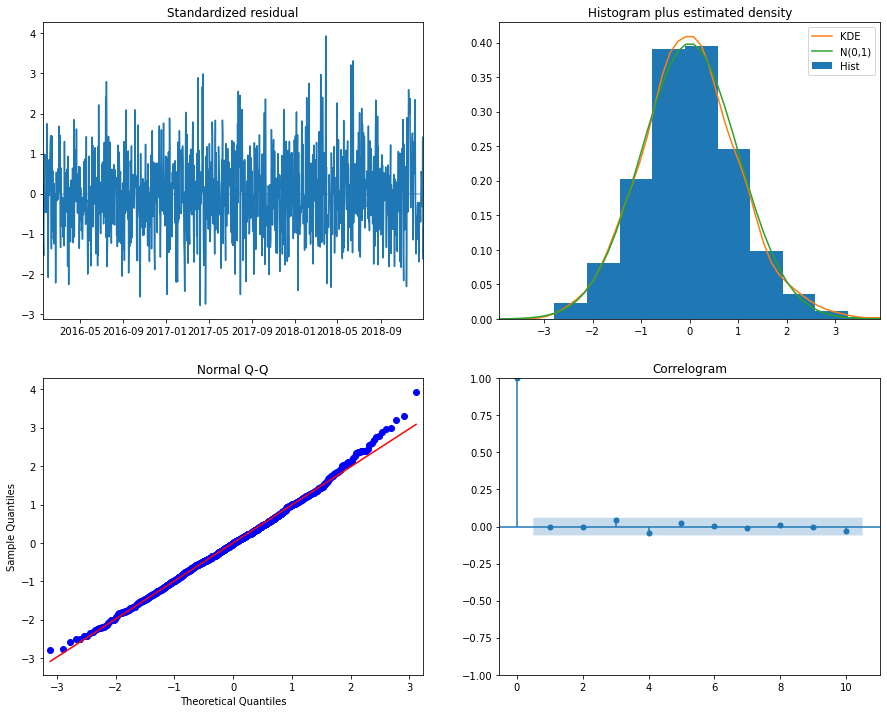

In [326]:
sarimax_new_2_2.plot_diagnostics(figsize=(15, 12))

#### Diagnostics for Brötchen

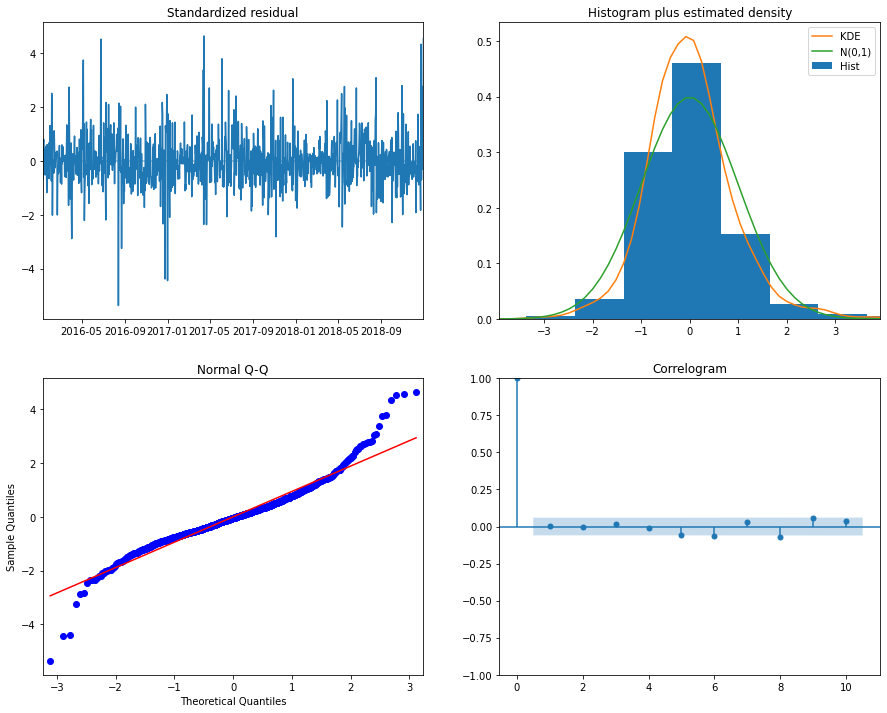

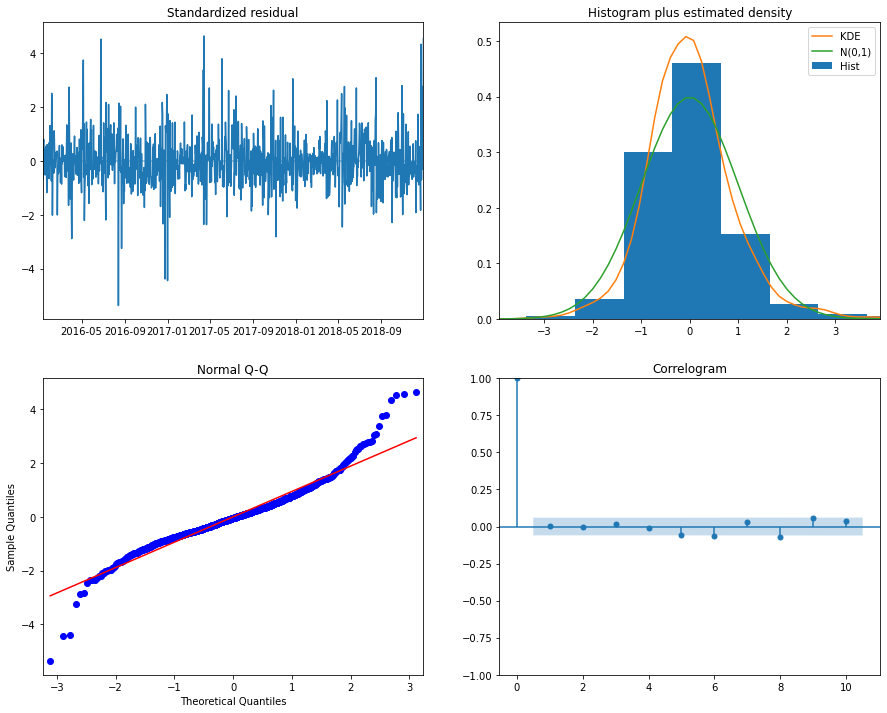

In [327]:
sarimax_adv_2_6.plot_diagnostics(figsize=(15, 12))

In [328]:
res_df_6_adv=pd.DataFrame(sarimax_adv_2_6.resid,columns=['resid'])

In [329]:
res_df_6.nlargest(5,'resid')

resid
Datum                 
2016-06-25  249.664380
2018-12-31  230.611400
2018-12-24  217.910092
2017-06-05  216.660797
2017-04-15  207.999549

#### Diagnostics for Süsse Brötchen

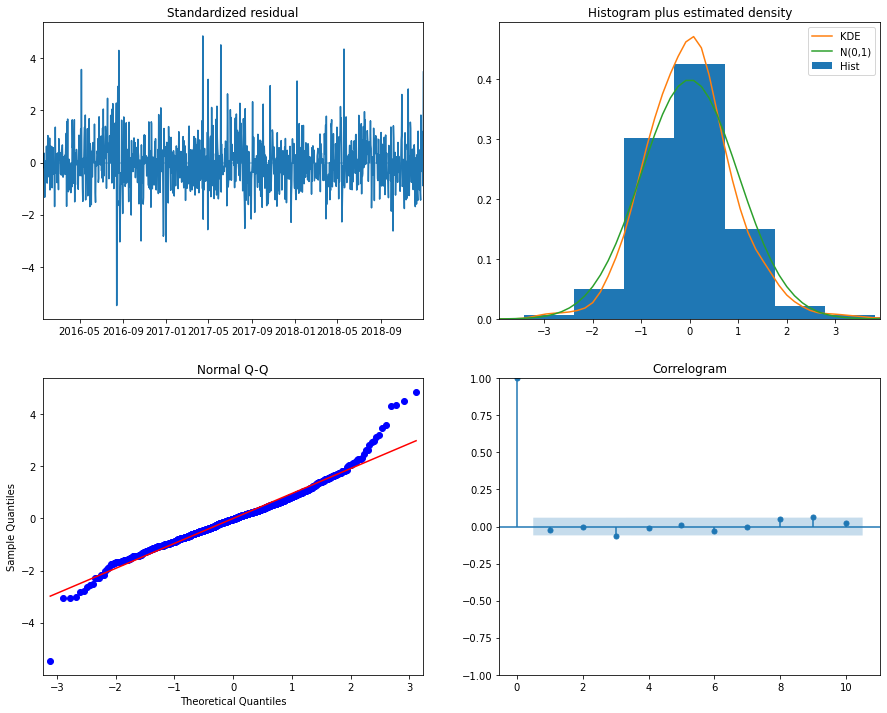

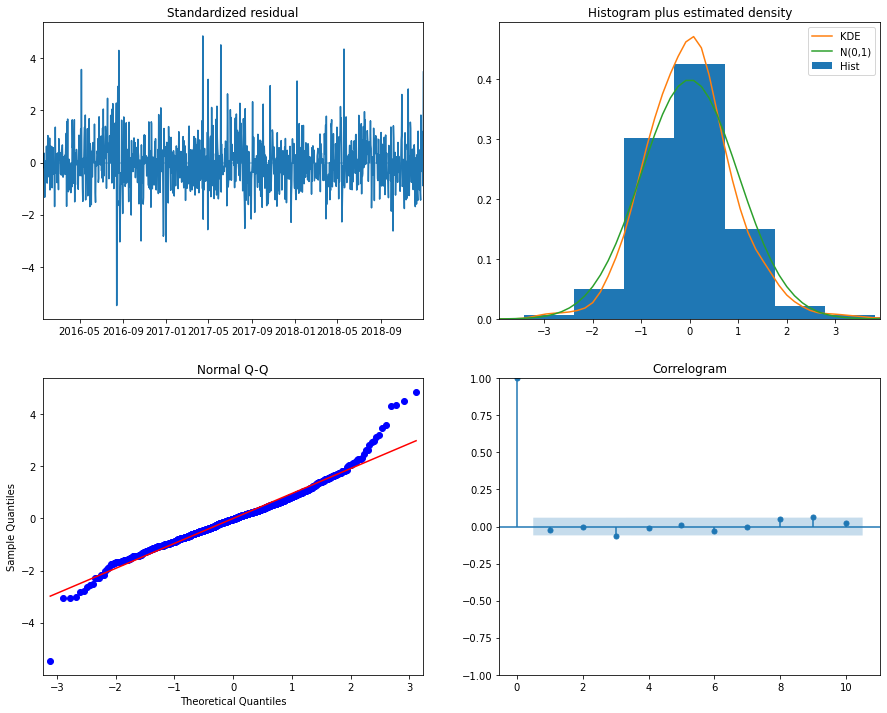

In [322]:
sarimax_new_2_7.plot_diagnostics(figsize=(15, 12))

#### Diagnostics for Stückgebäck

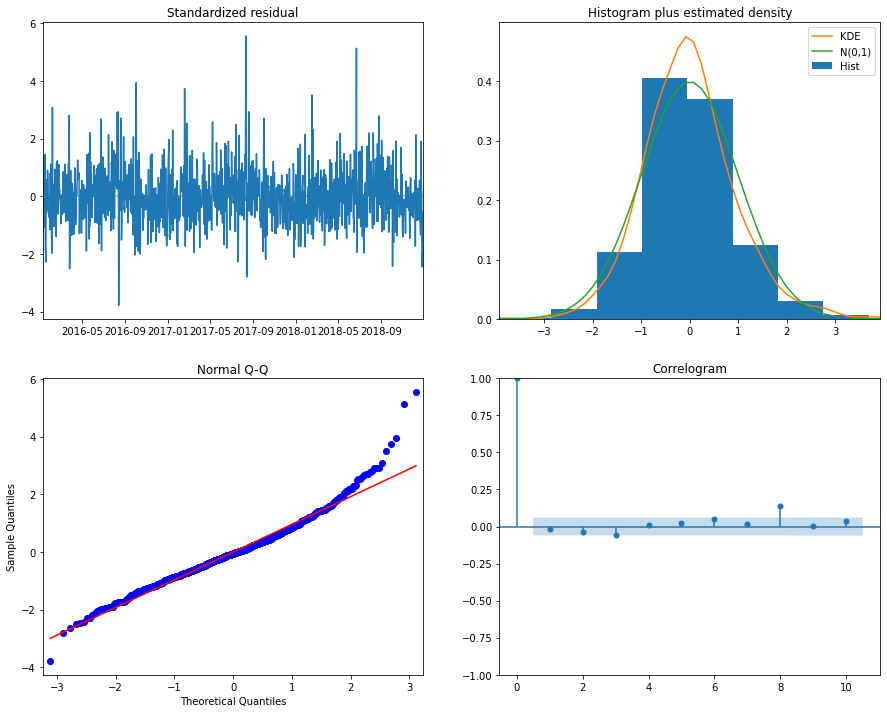

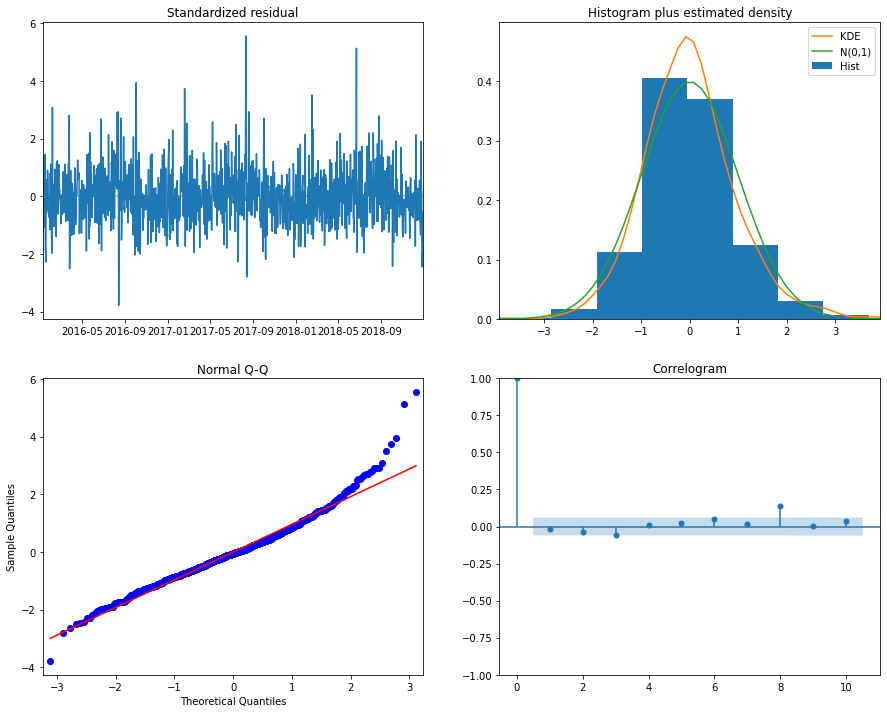

In [323]:
sarimax_new_2_11.plot_diagnostics(figsize=(15, 12))

In [324]:
res_df_11_new=pd.DataFrame(sarimax_new_2_11.resid,columns=['resid'])

In [325]:
res_df_11_new.nlargest(5,'resid')

resid
Datum                 
2017-08-12  165.396961
2018-06-23  152.681522
2016-10-03  117.236353
2017-02-18  111.162530
2018-02-16  104.479472

#### Diagnostics for Weihnachtsartikel

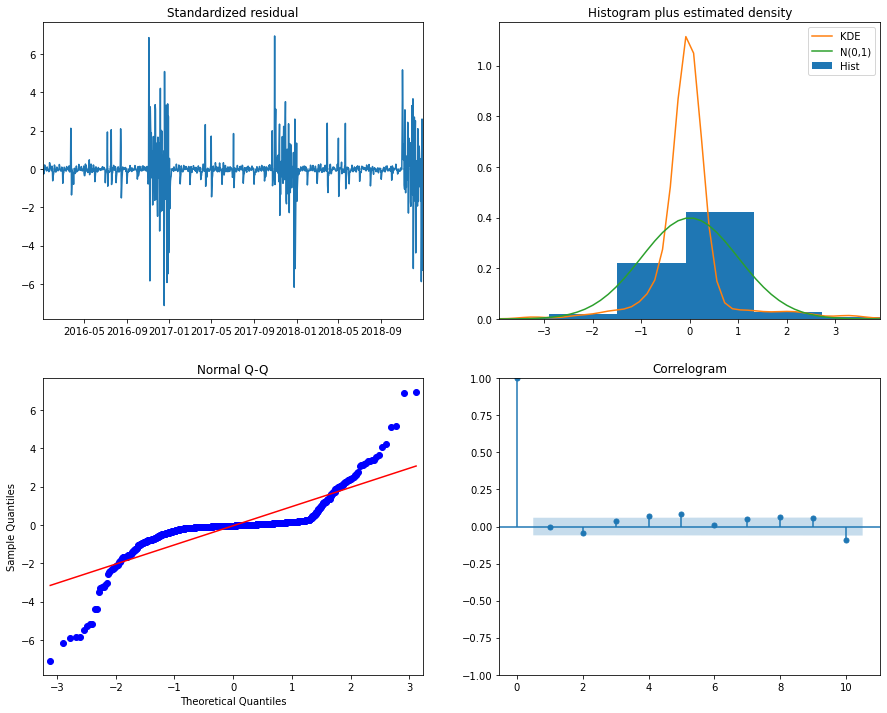

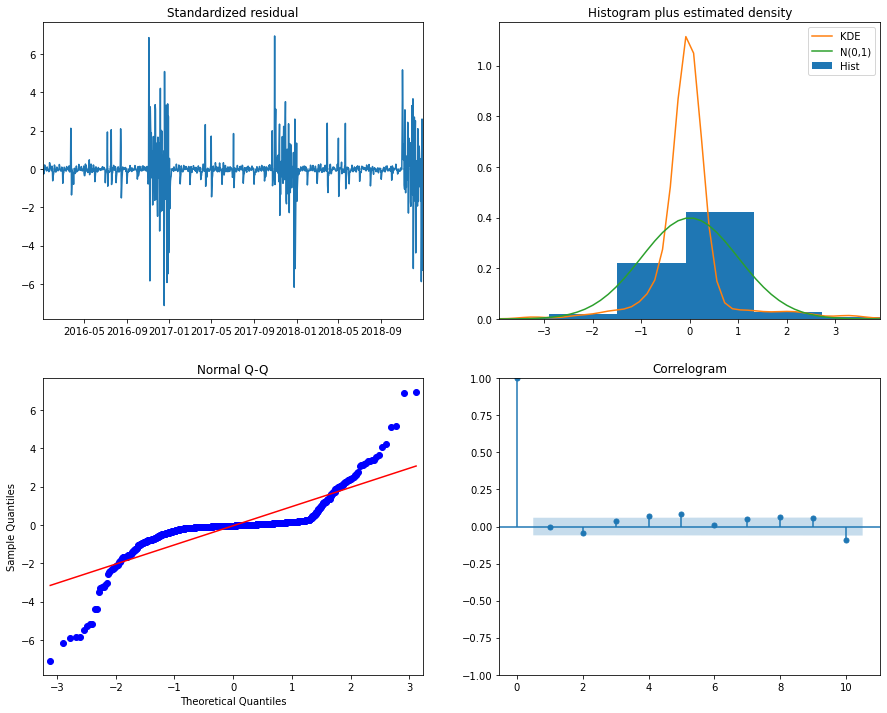

In [290]:
sarimax_new_2_12.plot_diagnostics(figsize=(15, 12))

### Optimazation 

#### Differencing

**Conclusions**
- `After the first differencation is the timesseries stationary.It is Integrated(1). `


In [291]:
adf_test_long_einzel(train_new_2['Brötchen'])

Ergebnis für Timeseries:
Test Statistic            -2.554666
p-value                    0.102733
# Lags                    55.000000
# Observations          1040.000000
Critical Value (1%)       -3.436653
Critical Value (5%)       -2.864323
Critical Value (10%)      -2.568252
dtype: float64
 Series is Non-Stationary


In [292]:
train_new_2['Brötchen'].diff().dropna()

Datum
2016-01-02    513.212373
2016-01-03    -55.017806
2016-01-04   -171.290047
2016-01-05     21.913730
2016-01-06    -55.473883
                 ...    
2018-12-27    488.618722
2018-12-28    -66.708315
2018-12-29     54.529782
2018-12-30     33.658732
2018-12-31    109.036188
Name: Brötchen, Length: 1095, dtype: float64

In [293]:
#ADF-test(differenced-time-series)
adf_test_long_einzel(train_new_2['Brötchen'].diff().dropna())


 Series is Stationary
Test Statistic            -5.236324
p-value                    0.000007
# Lags                    54.000000
# Observations          1040.000000
Critical Value (1%)       -3.436653
Critical Value (5%)       -2.864323
Critical Value (10%)      -2.568252
dtype: float64


In [294]:
test_new_2['Brötchen'].diff().dropna()

Datum
2019-01-02    418.883686
2019-01-03    -67.503505
2019-01-04    -30.111475
2019-01-05     37.316530
2019-01-06     43.642456
                 ...    
2020-03-11     53.771387
2020-03-12    -47.313414
2020-03-13     73.239408
2020-03-14    116.512224
2020-03-15    118.516984
Name: Brötchen, Length: 439, dtype: float64

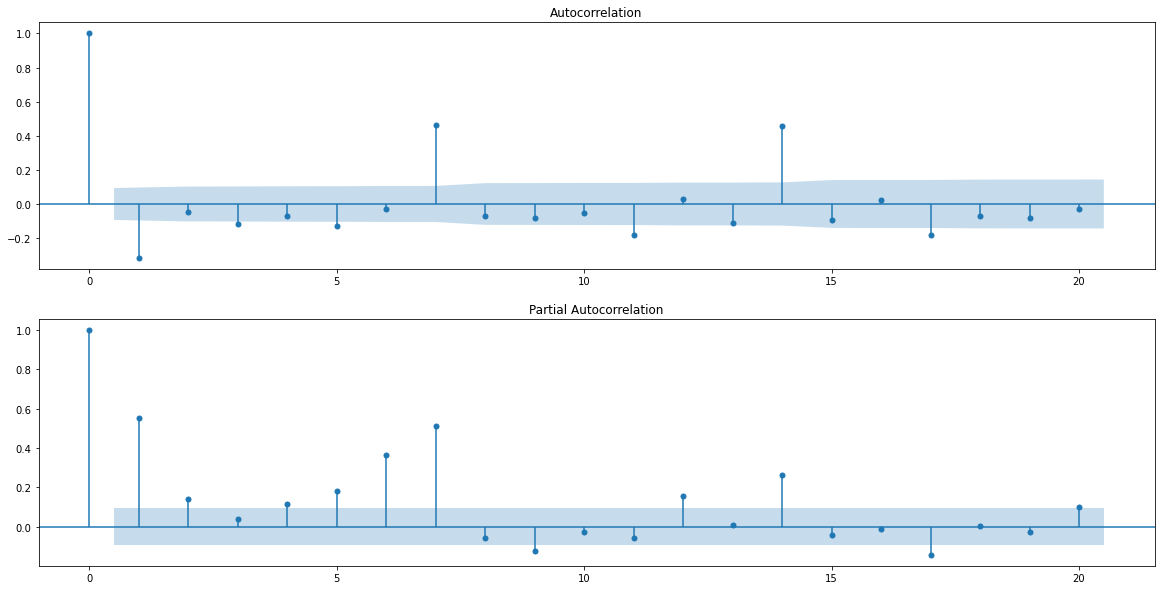

In [295]:
# use diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(test_new_2['Brötchen'].diff().dropna(), lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(test_new_2['Brötchen'].dropna(), lags=20, ax=ax[1])
plt.show()

In [296]:
model_autoarima_6 = auto_arima(train_basis_2['Brötchen'],d=1,p=7,Seasonal=True, m=7)
model_autoarima_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -8673.538
Date:                                Wed, 11 Nov 2020   AIC                          17357.076
Time:                                        18:48:33   BIC                          17383.507
Sample:                                             0   HQIC                         17366.936
                                               - 1461                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2493      0.017     14.464      0.000       0.216       0.283
ma.L1         -0.9350      0.011    -83.064      0.000      -0.957      -0.913
ma.S.L7        0.3757      0.017     22.767      0.000       0.343       0.408
ma.S.L14       0.2023      0.025      8.146      0.000       0.154       0.251
sigma2      8450.8066    171.926     49.154      0.000    8113.838    8787.775
===================================================================================
Ljung-Box (Q):                      361.34   Jarque-Bera (JB):              2373.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.50
Prob(H) (two-sided):                  0.23   Kurtosis:                         9.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

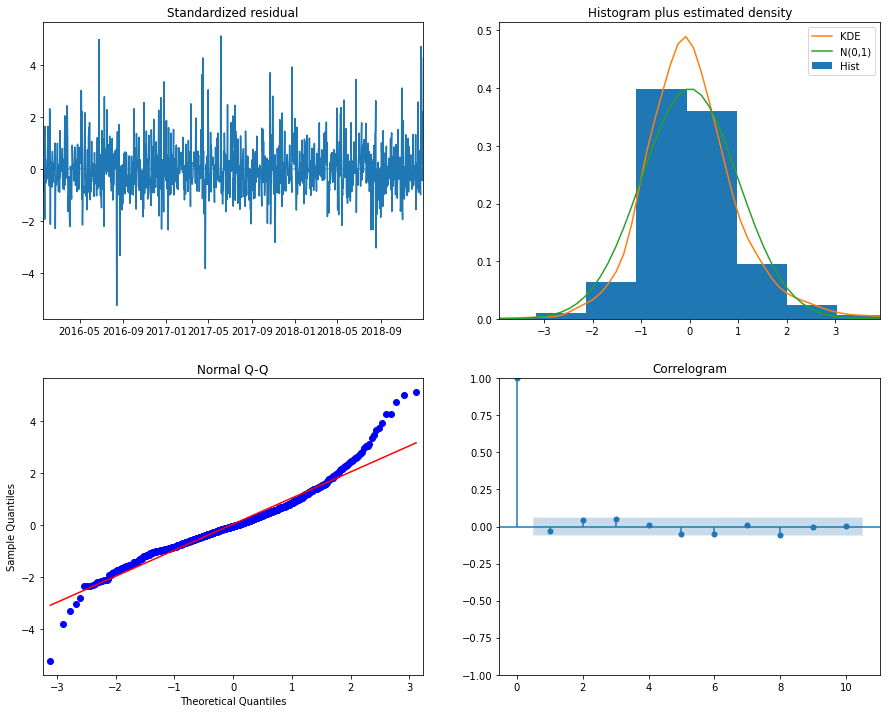

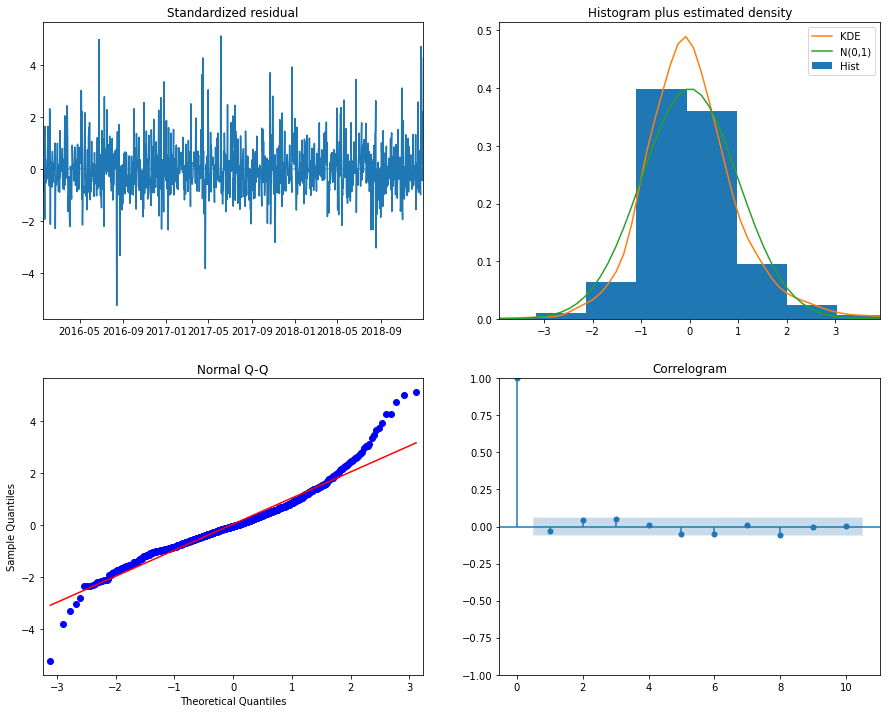

In [298]:
sarimax_new_2_6diff.plot_diagnostics(figsize=(15, 12))

In [297]:
# Model fit
sarimax_new_2_6diff = sm.tsa.statespace.SARIMAX(train_new_2['Brötchen'],order=(1, 1, 1), seasonal_order=(0, 0, [1, 2], 7)
                                             ,exog = exog_train_new_2,enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
#sarimax_new_2_6.summary()

In [299]:
pred_new_2_6diff = sarimax_new_2_6diff.get_prediction(start=start_test,end=corona,exog = exog_test_new_2)

In [300]:
MAE_6n2=(mean_absolute_error(test_new_2['Brötchen'],pred_new_2_6diff.predicted_mean['01.01.2019':'15.03.2020']))
MAPE_6n2=(mean_absolute_percentage_error(test_new_2['Brötchen'],pred_new_2_6diff.predicted_mean['01.01.2019':'15.03.2020']))

print('Results for Basismodel-Articlegroup Brötchen:')
print('SARIMAX model MAE: {0:.2f}'.format(MAE_6n2))
print('SARIMAX model MAPE: {0:.2f}%'.format(MAPE_6n2))

df_results_Sarimax.loc['13',:] = ['SARIMAX-BASIS-Diff','Brötchen',MAE_6n2,MAPE_6n2]

Results for Basismodel-Articlegroup Brötchen:
SARIMAX model MAE: 112.67
SARIMAX model MAPE: 26.04%


In [169]:
sarimax_new_2_6year=sm.tsa.arima.ARIMA(train_new_2['Brötchen'],order=(1, 1, 1), seasonal_order=(0, 0, [1, 2], 365))

In [171]:
#res = sarimax_new_2_6year.fit(method='innovations_mle', low_memory=True, cov_type='none')

#### Shorter Timeperiod

In [164]:
train_short_2=test_basis_2['01.01.2019':'31.12.2019']
test_short_2=test_basis_2['01.01.2020':]

In [168]:
# Model fit
sarima_short_2_6 = sm.tsa.statespace.SARIMAX(train_short_2['Brötchen'],order=(1,1,1),seasonal_order=(0,0,1,7),
                                enforce_stationarity=True, enforce_invertibility=False,freq='D').fit()
#sarima_basis_2_6.summary()

pred_short_2_6 = sarima_short_2_6.predict('01.01.2020','15.03.2020')[:]

MAE_6=(mean_absolute_error(test_short_2['01.01.2020':'15.03.2020']['Brötchen'],pred_short_2_6))
MAPE_6=(mean_absolute_percentage_error(test_short_2['01.01.2020':'15.03.2020']['Brötchen'],pred_short_2_6))
print('Results for Basismodel-Articlegroup Brötchen:')
print('SARIMA model MAE: {0:.2f}'.format(MAE_6))
print('SARIMA model MAPE: {0:.2f}%'.format(MAPE_6))

#df_results_Sarima.loc['6',:] = ['SARIMA-BASIS','Brötchen',MAE_6,MAPE_6]

Results for Basismodel-Articlegroup Brötchen:
SARIMA model MAE: 116.35
SARIMA model MAPE: 40.59%


# VARMAX

# PROPHET

## Übersicht Ergebnisse

In [764]:
df_results_Prophet = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [765]:
df_results_Prophet

Empty DataFrame
Columns: [Model, Label, MAE, MAPE]
Index: []

In [385]:
df_results_Prophet.to_csv("df_results_Prophet_Basis.csv")

## Prophet Basis Model

In [200]:
article_selection_short=['Brötchen']

In [381]:
article_selection=df_newmodel_2.iloc[:,0:12].columns.tolist()
#article_selection

In [ ]:
for article in article_selection:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet()
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify_brötchen = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet=df_results_Prophet.append({'Model' : 'Prophet-Basis' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')

### First Look to Brötchen

In [788]:
for article in article_selection_short:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet()
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify_brötchen = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify_brötchen.query('ds>="2019-01-01"')['y'],verify_brötchen.query('ds>="2019-01-01"')['yhat'])
    #df_results_Prophet=df_results_Prophet.append({'Model' : 'Prophet-Basis' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Article Brötchen, MAE:54.67256691397481
Article Brötchen, MAPE:12.44190338238444


#### Plots

In [789]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=verify_brötchen.query('ds>="2019-01-01"')['ds'], y=verify_brötchen.query('ds>="2019-01-01"')['y'], name='Actual',))
fig.add_trace(go.Scatter(x=verify_brötchen.query('ds>="2019-01-01"')['ds'], y=verify_brötchen.query('ds>="2019-01-01"')['yhat'], name='Predicted',))

fig.show()

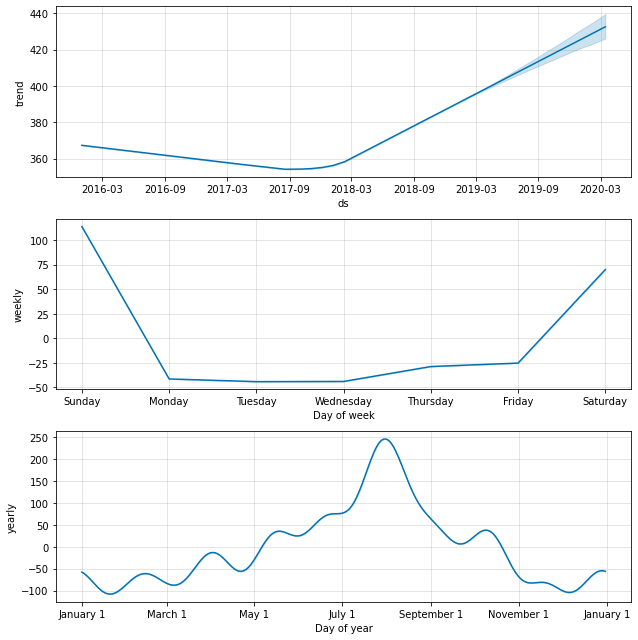

In [250]:
# Plot of the components
fig2 = model.plot_components(prediction)

#### Correlations

In [761]:
data=pd.concat([data_train,data_test])

In [762]:
verify = pd.merge(prediction, data, on='ds')

In [770]:
verify_ohne_closed=verify.query('y>0')
#verify_ohne_closed[['ds','y','yhat']]

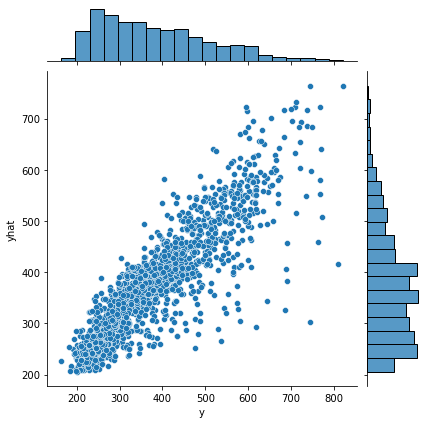

In [759]:
# Show jointplot for data without closed days
sns.jointplot(data=verify_ohne_closed.loc['2016':,:], x=verify_ohne_closed.y, y=verify_ohne_closed.yhat)

In [721]:
#sns.plot_joint_plot(verify.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [724]:
# Correlation for period
verify.loc['2016':,['y','yhat']].corr()

y      yhat
y     1.000000  0.827017
yhat  0.827017  1.000000

In [775]:
residuals=(verify_ohne_closed.query('ds>="2019-01-01"')['y'] - verify_ohne_closed.query('ds>="2019-01-01"')['yhat'])

Text(0.05, 0.85, 'Median = +10.58\nMean = +9.24')

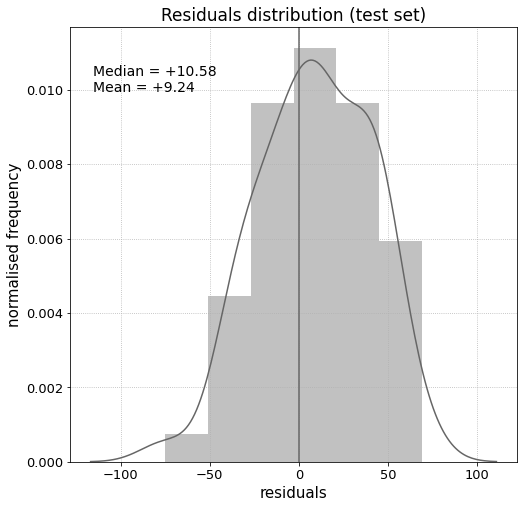

In [779]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot((verify_ohne_closed.query('ds>="2019-01-01"')['y'] - verify_ohne_closed.query('ds>="2019-01-01"')['yhat']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Median = {:+1.2f}\nMean = {:+4.2f}".\
        format(residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

## PROPHET with Seasonal Dependencies

In [791]:
df_results_Prophet_Saison = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [852]:
df_results_Prophet_Saison.query('Label=="Brötchen"')

Model     Label        MAE       MAPE
5        Prophet-Saison  Brötchen  54.672567  12.441903
17  Prophet-Saison-mult  Brötchen  50.776546  10.937751

In [394]:
#df_results_Prophet_Saison.sort_values(['Label','MAE']),seasonality_mode='multiplicative'

In [797]:
for article in article_selection:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(weekly_seasonality=True,yearly_seasonality=True,seasonality_mode='multiplicative')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Saison=df_results_Prophet_Saison.append({'Model' : 'Prophet-Saison-mult' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    #print(f'Article {article}, MAE:{MAE}')
    #print(f'Article {article}, MAPE:{MAPE}')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

### Look at Stückgebäck 

In [804]:
article_selection_spez=['Stückgebäck']

In [805]:
for article in article_selection_spez:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(daily_seasonality=True,yearly_seasonality=True,seasonality_mode='multiplicative')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    #df_results_Prophet_Saison=df_results_Prophet_Saison.append({'Model' : 'Prophet-Saison-mult' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')

Article Stückgebäck, MAE:43.910831655035615
Article Stückgebäck, MAPE:26.298907567641745


In [806]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=verify.query('ds>="2019-01-01"')['ds'], y=verify.query('ds>="2019-01-01"')['y'], name='Actual',))
fig.add_trace(go.Scatter(x=verify.query('ds>="2019-01-01"')['ds'], y=verify.query('ds>="2019-01-01"')['yhat'], name='Predicted',))

fig.show()

In [829]:
verify.nlargest(5,'y')[['y']]

y
1460  1774.478230
365   1639.124849
1095  1606.948186
730   1386.356115
1459   467.552229

In [832]:
# The prediction is not so bad in case of not considering the outliner. 
verify_ohne_CE=verify.query('y<1000')

In [833]:
MAE= (mean_absolute_error(verify_ohne_CE.query('ds>="2019-01-01"')['y'],
     verify_ohne_CE.query('ds>="2019-01-01"')['yhat']))
MAE

40.50924519258001

In [834]:
MAPE=mean_absolute_percentage_error(verify_ohne_CE.query('ds>="2019-01-01"')['y'],
                                    verify_ohne_CE.query('ds>="2019-01-01"')['yhat'])
MAPE

26.158278698433545

### Look to Brötchen again

In [838]:
for article in article_selection_short:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    #df_results_Prophet_Saison=df_results_Prophet_Saison.append({'Model' : 'Prophet-Saison-mult' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')

Article Brötchen, MAE:50.82505336762572
Article Brötchen, MAPE:10.966561889340184


## PROPHET with Holidays

In [839]:
df_results_Prophet_Holiday = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [853]:
df_results_Prophet_Holiday.query('Label=="Brötchen"')

Model     Label        MAE       MAPE
5          Prophet-Holiday  Brötchen  46.633617  10.904981
17      Prophet-Holiday-KW  Brötchen  46.223699  10.885921
29  Prophet-Holiday-SOMMER  Brötchen  48.566345  11.352737
41    Prophet-Holiday-ALLE  Brötchen  49.170825  11.461367
53  Prophet-Holiday-CLOSED  Brötchen  45.324669  11.343873

### Celebration Days

In [ ]:
for article in article_selection:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.add_country_holidays(country_name='DE')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Holiday=df_results_Prophet_Holiday.append({'Model' : 'Prophet-Holiday' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')

### Kieler Woche

In [842]:
for article in article_selection:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(holidays=Kieler_Woche,daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.add_country_holidays(country_name='DE')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Holiday=df_results_Prophet_Holiday.append({'Model' : 'Prophet-Holiday-KW' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    #print(f'Article {article}, MAE:{MAE}')
    #print(f'Article {article}, MAPE:{MAPE}')

### Schoolholidays Schleswig Holstein - only Summer

In [218]:
HOLIDAYS_SH_SOMMER

holiday         ds  lower_window  upper_window
0  Sommer 2015-07-20            -2            42
1  Sommer 2016-07-25            -2            42
2  Sommer 2017-07-24            -2            42
3  Sommer 2018-07-09            -2            42
4  Sommer 2019-07-01            -2            42

In [844]:
holidays_sommer = pd.concat((HOLIDAYS_SH_SOMMER, Kieler_Woche))

In [845]:
for article in article_selection:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(holidays=holidays_sommer,daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.add_country_holidays(country_name='DE')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Holiday=df_results_Prophet_Holiday.append({'Model' : 'Prophet-Holiday-SOMMER' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    #print(f'Article {article}, MAE:{MAE}')
    #print(f'Article {article}, MAPE:{MAPE}')

### All Holidays (including Herbst and Ostern)

In [310]:
df_results_Prophet_Holiday_all = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [846]:
holidays_all = pd.concat((HOLIDAYS_SH_SOMMER, HOLIDAYS_SH_ALL,Kieler_Woche))

In [848]:
for article in article_selection:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(holidays=holidays_all,daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.add_country_holidays(country_name='DE')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Holiday=df_results_Prophet_Holiday.append({'Model' : 'Prophet-Holiday-ALLE' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    #print(f'Article {article}, MAE:{MAE}')
    #print(f'Article {article}, MAPE:{MAPE}')

### Closed Flag

In [849]:
holidays_all_cl = pd.concat((HOLIDAYS_SH_SOMMER,Kieler_Woche,Closed))

In [314]:
df_results_Prophet_Holiday_Closed = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [850]:
for article in article_selection:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(holidays=holidays_all_cl,daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.add_country_holidays(country_name='DE')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Holiday=df_results_Prophet_Holiday.append({'Model' : 'Prophet-Holiday-CLOSED' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    #print(f'Article {article}, MAE:{MAE}')
    #print(f'Article {article}, MAPE:{MAPE}')

### Optimization for Brötchen

**Conclusions**
- `The best value is shown considering only german Feiertage and Kieler Woche.`

In [854]:
holidays_brötchen = pd.concat((Kieler_Woche,Closed))

In [ ]:
'changepoint_prior_scale': 0.01, 'changepoint_range': 0.3, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.5, 

In [1002]:
for article in article_selection_short:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data=pd.concat([data_train,data_test])
    
    model = Prophet(changepoint_prior_scale=0.04, changepoint_range= 0.5,holidays=holidays_brötchen,daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.add_country_holidays(country_name='DE')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    prediction = model.predict(future)
    verify_brötopt = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify_brötopt.query('ds>="2019-01-01"')['y'],verify_brötopt.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Holiday=df_results_Prophet_Holiday.append({'Model' : 'Prophet-Holiday-OPT' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')

Article Brötchen, MAE:44.1312081809618
Article Brötchen, MAPE:10.784546693143804


In [858]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=verify_brötopt.query('ds>="2019-01-01"')['ds'], y=verify_brötopt.query('ds>="2019-01-01"')['y'], name='Actual',))
fig.add_trace(go.Scatter(x=verify_brötopt.query('ds>="2019-01-01"')['ds'], y=verify_brötopt.query('ds>="2019-01-01"')['yhat'], name='Predicted',))

fig.show()

In [367]:
df_p.mean()

horizon     55 days 00:00:00
mse                  1407.32
rmse                  35.326
mae                  29.7777
mdape              0.0973594
coverage            0.901099
dtype: object

## Adding extra regressors like Wheather

In [868]:
df_results_Prophet_Wheather = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [916]:
df_results_Prophet_Wheather

Model               Label        MAE       MAPE
0   Prophet-WHEATHER-HolBröt          Weizenbrot  11.114998  17.033447
1   Prophet-WHEATHER-HolBröt           Mischbrot  11.991728  17.826322
2   Prophet-WHEATHER-HolBröt        Vollkornbrot  15.311085  13.292694
3   Prophet-WHEATHER-HolBröt        Stangenbrote  11.494499  35.027312
4   Prophet-WHEATHER-HolBröt         Spezialbrot  11.235213  18.839119
5   Prophet-WHEATHER-HolBröt            Brötchen  44.127428  11.116685
6   Prophet-WHEATHER-HolBröt      Süsse_Brötchen  19.090535   9.372954
7   Prophet-WHEATHER-HolBröt  Herzhafte_Brötchen  23.294362  23.824460
8   Prophet-WHEATHER-HolBröt     KonditoreiBlech  16.922924  22.427540
9   Prophet-WHEATHER-HolBröt         Stückgebäck  43.819048  29.889982
10  Prophet-WHEATHER-HolBröt         Blechkuchen  22.031371  25.336045
11  Prophet-WHEATHER-HolBröt   Weihnachtsartikel   7.951169  17.260996

In [945]:
data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
data_train['Temperatur']=train_new_2['Temperatur_max']
data_train['Temperatur_F']=(data_train['Temperatur']+5.1/(35.1+5.1))*10
data_train['Sonne']=train_new_2['Sonne_h']

#data_train.head()

In [943]:
data['Temperatur_F']=(data['Temperatur']+5.1/(35.1+5.1))*10

In [946]:
data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
data_test['Temperatur']=test_new_2['Temperatur_max']
data_train['Temperatur_F']=(data_train['Temperatur']+5.1/(35.1+5.1))*10
data_test['Sonne']=test_new_2['Sonne_h']
data_test['Sonne'] = data_test['Sonne'].interpolate(method='linear')
#data_test.tail()

In [948]:
for article in article_selection:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_train['Temperatur']=train_new_2['Temperatur_max']
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data_test['Temperatur']=test_new_2['Temperatur_max']
    data=pd.concat([data_train,data_test])
    
    model = Prophet(holidays=holidays_brötchen,daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.add_country_holidays(country_name='DE')
     # Adding the extra weather regressors
    model.add_regressor('Temperatur')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    future=future.merge(data_test, on='ds')
    prediction = model.predict(future)
    verify = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify.query('ds>="2019-01-01"')['y'],verify.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Wheather=df_results_Prophet_Wheather.append({'Model' : 'Prophet-WHEATHER-HolBröt' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')
   
    

Article Weizenbrot, MAE:11.114998296201044
Article Weizenbrot, MAPE:17.033446929193968
Article Mischbrot, MAE:11.99172843117973
Article Mischbrot, MAPE:17.82632194403279
Article Vollkornbrot, MAE:15.311085293770583
Article Vollkornbrot, MAPE:13.29269396917254
Article Stangenbrote, MAE:11.494498595629695
Article Stangenbrote, MAPE:35.02731240422692
Article Spezialbrot, MAE:11.23521280622804
Article Spezialbrot, MAPE:18.83911911971343
Article Brötchen, MAE:44.12742768511802
Article Brötchen, MAPE:11.116685225200772
Article Süsse_Brötchen, MAE:19.09053450056794
Article Süsse_Brötchen, MAPE:9.372954428471969
Article Herzhafte_Brötchen, MAE:23.29436205249732
Article Herzhafte_Brötchen, MAPE:23.8244595949956
Article KonditoreiBlech, MAE:16.922924307500573
Article KonditoreiBlech, MAPE:22.427539975178608
Article Stückgebäck, MAE:43.81904833347873
Article Stückgebäck, MAPE:29.889981728209335
Article Blechkuchen, MAE:22.03137092500023
Article Blechkuchen, MAPE:25.336044574010298
Article Weihnac

In [937]:
for article in article_selection_short:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_train['Temperatur']=train_new_2['Temperatur_max']
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data_test['Temperatur']=test_new_2['Temperatur_max']
    data=pd.concat([data_train,data_test])
    
    model = Prophet(changepoint_range=0.5,changepoint_prior_scale=0.5,holidays=holidays_brötchen,daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    model.add_country_holidays(country_name='DE')
     # Adding the extra weather regressors
    model.add_regressor('Temperatur')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    future=future.merge(data_test, on='ds')
    prediction = model.predict(future)
    verify_brötw = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify_brötw.query('ds>="2019-01-01"')['y'],verify_brötw.query('ds>="2019-01-01"')['yhat'])
    df_results_Prophet_Holiday=df_results_Prophet_Holiday.append({'Model' : 'Prophet-WHEATHER-HolBröt' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')

Article Brötchen, MAE:43.45876624976822
Article Brötchen, MAPE:10.69846687052472


In [944]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=verify_brötw.query('ds>="2019-01-01"')['ds'], y=verify_brötw.query('ds>="2019-01-01"')['y'], name='Actual',))
fig.add_trace(go.Scatter(x=verify_brötw.query('ds>="2019-01-01"')['ds'], y=verify_brötw.query('ds>="2019-01-01"')['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=data.query('ds>="2019-01-01"')['ds'], y=data.query('ds>="2019-01-01"')['Temperatur_F'], name='Temp',))
#fig.add_trace(go.Scatter(x=verify_brötw.query('ds>="2019-01-01"')['ds'], y=verify_brötw.query('ds>="2019-01-01"')['trend']), name='Trend',))

fig.show()

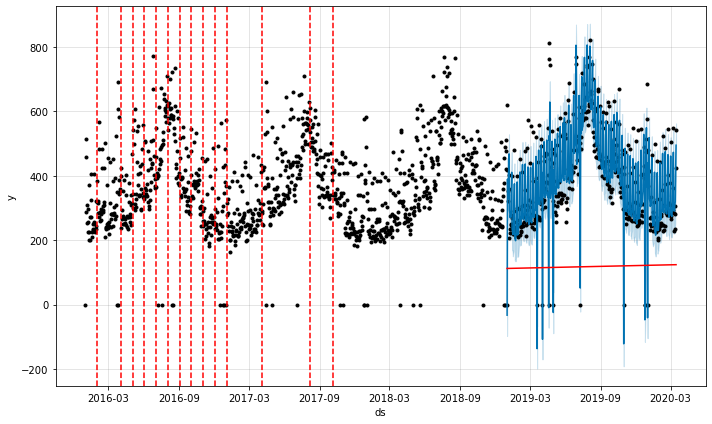

In [910]:
    pro_change = Prophet(changepoint_range=0.5,changepoint_prior_scale=0.5,holidays=holidays_brötchen,daily_seasonality=True,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='multiplicative')
    pro_change.add_country_holidays(country_name='DE')
    forecast = pro_change.fit(data).predict(future)
    fig= pro_change.plot(forecast);
    a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

Article Weihnachtsartikel, MAE:373.56451988522315


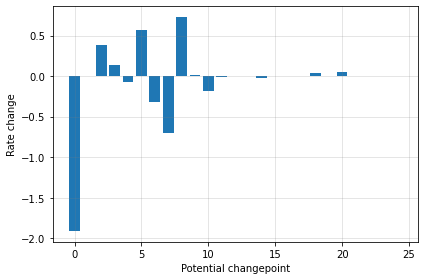

In [927]:
deltas = pro_change.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

MAE = (mean_absolute_error(test_new_2[article],
forecast.loc[(forecast['ds']>= test_new_2.index.min())]['yhat']))
print(f'Article {article}, MAE:{MAE}')

## Tuning hyperparameters & Optimazation

In [951]:
df_results_Prophet_Opt = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

### Stangenbrot

In [1009]:
for article in ['Stangenbrote']:
    data_train = pd.DataFrame.from_dict({'ds':train_new_2.index,'y':train_new_2[article]})
    data_train['Temperatur']=train_new_2['Temperatur_max']
    data_test = pd.DataFrame.from_dict({'ds':test_new_2.index,'y':test_new_2[article]})
    data_test['Temperatur']=test_new_2['Temperatur_max']
    data=pd.concat([data_train,data_test])
    
    model = Prophet(changepoint_range=1.0,changepoint_prior_scale=0.05,holidays=holidays_brötchen,
                    daily_seasonality=False,yearly_seasonality=True,weekly_seasonality=True,seasonality_mode='additive')
    model.add_country_holidays(country_name='DE')
     # Adding the extra weather regressors
    model.add_regressor('Temperatur')
    model.fit(data_train)
    future = model.make_future_dataframe(440)
    future=future.merge(data_test, on='ds')
    prediction = model.predict(future)
    verify_stangenbrot_opt = pd.merge(prediction, data, on='ds')
    
    MAE = (mean_absolute_error(test_new_2[article],
     prediction.query('ds>="2019-01-01"')['yhat']))
    MAPE=mean_absolute_percentage_error(verify_stangenbrot_opt.query('ds>="2019-01-01"')['y'],verify_stangenbrot_opt.query('ds>="2019-01-01"')['yhat'])
    #df_results_Prophet_Opt=df_results_Prophet_Opt.append({'Model' : 'Prophet-WHEATHER-HolBröt' , 'Label' : article, 'MAE' : MAE,'MAPE' : MAPE} , ignore_index=True)
    print(f'Article {article}, MAE:{MAE}')
    print(f'Article {article}, MAPE:{MAPE}')

Article Stangenbrote, MAE:11.460563200573022
Article Stangenbrote, MAPE:35.4614227764472


In [1010]:
data.head()

ds          y  Temperatur
Datum                                       
2016-01-01 2016-01-01   0.000000         5.4
2016-01-02 2016-01-02  46.134893         4.2
2016-01-03 2016-01-03   0.000000        -4.8
2016-01-04 2016-01-04  38.924403        -5.1
2016-01-05 2016-01-05  39.336646        -2.3

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=verify_stangenbrot_opt.query('ds>="2019-01-01"')['ds'], y=verify_stangenbrot_opt.query('ds>="2019-01-01"')['y'], name='Actual',))
fig.add_trace(go.Scatter(x=verify_stangenbrot_opt.query('ds>="2019-01-01"')['ds'], y=verify_stangenbrot_opt.query('ds>="2019-01-01"')['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=data.query('ds>="2019-01-01"')['ds'], y=data.query('ds>="2019-01-01"')['Temperatur_F'], name='Temp',))
#fig.add_trace(go.Scatter(x=verify_brötw.query('ds>="2019-01-01"')['ds'], y=verify_brötw.query('ds>="2019-01-01"')['trend']), name='Trend',))

fig.show()

## Optimazation

Prophet has quite a few parameters for you to tune. I’m going to test different hyper-parameters in a loop and then pick the best ones. 

### Considering Cross-Validation

INFO:fbprophet:Making 21 forecasts with cutoffs between 2017-01-10 00:00:00 and 2018-09-22 00:00:00


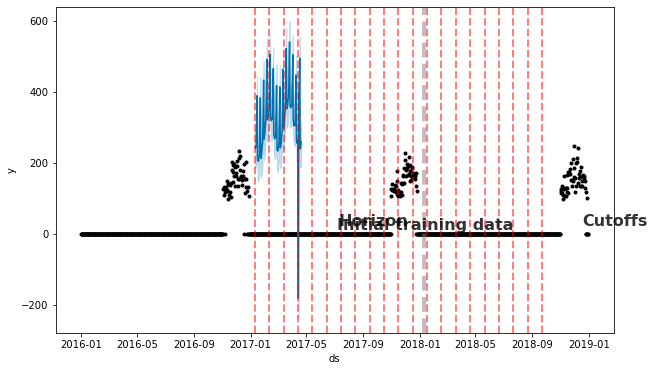

In [1004]:
# Fit the model with three years of data and define a horizon of 440 days forcasting per month
df_cv = cross_validation(model, initial='365 days', period = '31 days', horizon = '100 days')
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(model_holiday.history['ds'].values, model_holiday.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

#ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2017-07-07'),y=12, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2018-12-17'),y=24, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('180 days'),y=24, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

In [1005]:
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Skipping MAPE because y close to 0


horizon          mse       rmse        mae     mdape  coverage
0 10 days  1460.100124  38.211257  28.668752  0.093356       0.8
1 11 days   921.606927  30.357980  23.365557  0.083128       0.9
2 12 days   789.453228  28.097210  21.614330  0.075415       0.9
3 13 days   858.019409  29.291968  24.042207  0.083128       0.9
4 14 days   455.364322  21.339267  17.762428  0.075415       1.0

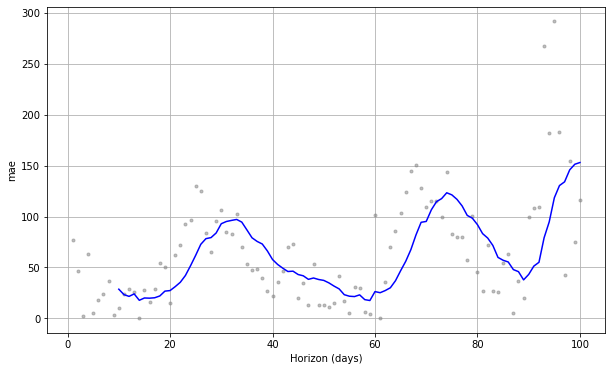

In [1006]:
fig=plot_cross_validation_metric(df_cv, metric='mae')


In [874]:
def getCrossValidationData(m):
    return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

In [875]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

In [876]:
holiday = pd.concat((HOLIDAYS_SH_SOMMER,Kieler_Woche,Closed))

In [299]:
#holiday

In [877]:
def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(holidays=holiday)
    m.add_country_holidays(country_name='DE')
    # Adding the extra weather regressors
   # m.add_regressor('rain')
    #m.add_regressor('temp')
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [1012]:

pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],
                 'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
                 'seasonality_prior_scale':[0.5, 1.0, 2.5, 5],
                 'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
                  'yearly_seasonality':[5, 10, 15, 20],
              }
metrics = ['horizon', 'rmse', 'mae', 'mdape','params'] 
results = []

In [ ]:
#Prophet(,)
params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(data,  metrics, param_dict, parallel="processes")
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['mae'] == min(results_df['mae']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2018-01-06 00:00:00 and 2019-03-16 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Holt Winter’s Exponential Smoothing (HWES)